In [2]:
import dm_den
import dm_den_viz
import pickle
import paths
import numpy as np
import pandas as pd
import scipy
from importlib import reload
from progressbar import ProgressBar

import matplotlib as mpl
from matplotlib import pyplot as plt

from astropy import units as u

import scipy
#from scipy.stats.stats import pearsonr
from scipy import integrate

# Cautionary note
Please note that as of now, in some places of the following code I accidentally say $f(v)$ when I mean $p(v)$. $p(v)=f(v)\,4\pi v^2$. I didn't realize this until recently, and I haven't yet gone through and corrected the variable names. Whenever you see $f(v)$, please use context to check whether I meant $f(v)$ or $p(v)$.


# Getting started

In [3]:
with open('./data/v_pdfs.pkl','rb') as f:
    pdfs_v=pickle.load(f)
vs_pdfs=np.array([pdfs_v[galname]['bins'] 
                  for galname in pdfs_v]).flatten()
vs_shm=np.linspace(vs_pdfs.min(), vs_pdfs.max(), 70)
with open('./data/vescs_20221222.pkl', 'rb') as f:
        vesc_dict = pickle.load(f)
with open('./data/v_pdfs_incl_ve_20220205.pkl','rb') as f:
    pdfs_v_incl_vearth=pickle.load(f)

In [4]:
def shm(vmag, sigma=200.*u.km/u.s / np.sqrt(2.), use='3d'):
    vmag*=u.km/u.s
    if use=='3d':
        f = (3. / (2.*np.pi*sigma**2.))**(3./2.) * np.exp(-3.*vmag**2. / (2.*sigma**2.))        
    elif use=='iso':
        f = 1. / (2.*np.pi*sigma**2.)**(3./2.) * np.exp(-(vmag)**2. / (2.*sigma**2.))
    elif use=='simple':
        # By "simple" I mean not including the 1/2 factor in the exponential,
        # just to see what happens.
        f = 1. / (np.pi*sigma**2.)**(3./2.) * np.exp(-vmag**2./sigma**2.)
    elif use=='simple3d':
        # Maybe we get a better result if we assume sigma in the "simple" model
        # is isothermal, so we convert it to 3d here
        f = (3. / (np.pi*sigma**2.))**(3./2.) * np.exp(-3.*vmag**2./sigma**2.)
    p = f*vmag**2.*4.*np.pi
    return p.to(u.s/u.km).value

## Defining distribution functions

In [5]:
def gen_max(v,v0,a):
    f = 4.*np.pi*v**2.*np.exp(-(v/v0)**(2.*a))
    N = 4./3.*np.pi * v0**3. * scipy.special.gamma(1.+3./(2.*a))
    return f / N

def gen_gauss(x,mu,x0,a):
    y=-(((x-mu)/x0)**2.)**a
    f = np.exp(y)
    N = 2.*x0*scipy.special.gamma(1.+1./2./a)
    '''print(mu)
    print(x0)
    print('alpha={0:0.20f}'.format(a))'''
    return f/N

def trunc_max_simple(v, v0, vesc):
    vesc = np.float64(vesc)
    v0 = np.float64(v0)
    N1 = np.sqrt(np.pi) * v0 * scipy.special.erf(vesc/v0)
    N2 = 2*vesc * np.exp( - vesc**2. / v0**2. )
    N = np.pi*v0**2. * (N1 - N2)
    f = np.exp( - v**2. / v0**2. )
    f /= N
    jacobian = 4*np.pi*v**2.
    p = f * jacobian
    if isinstance(v,(list,np.ndarray)):
        isesc = v>=vesc
        p[isesc] = 0.
    else:
        if v>=vesc:
            return 0.
    return p

def trunc_max(v,v0,a,vesc):
    f = v**2.*np.exp(-(v/v0)**(2.*a))
    g1 = scipy.special.gamma(3./2./a)
    g2 = g1 * scipy.special.gammaincc(3./2./a, 
                                 (v0/vesc)**(-2.*a))
    N = v0**3./2./a * (g1 - g2)
    p = f/N
    
    if isinstance(v,(list,np.ndarray)):
        isesc = v>=vesc
        p[isesc] = 0.
    else:
        if v>=vesc:
            return 0.

    return p

def exp_trunc_max(v,v0,a,vesc):
    '''
    Exponentially truncated Maxwellian, as opposed to the immediate cutoff
    of a Heaviside function used in trunc_max
    '''
    def f(v,v0,a,vesc):
        return v**2.*np.exp(-(v/v0)**(2.*a)) / (1.+np.exp(-(vesc-v)/v0/0.3))
    N = scipy.integrate.quad(f,0.,np.inf,(v0,a,vesc))[0]
    return f(v,v0,a,vesc) / N

def g_trunc_max_simple(vmin, v0, vesc):   
    def integrand(v):
        # p(vmin) = 4pi v^2 f(v)
        # g(vmin) = int f(v)/v (4pi v^2 dv) 
        #         = int p(v) / (4pi v^2) v^2/v 4pi dv
        #         = int p(v)/v dv
        p = trunc_max_simple(v, v0, vesc)
        return p/v
    listlike = (list, tuple, set, np.ndarray)
    if isinstance(vmin, listlike):
        g = [scipy.integrate.quad(integrand, vmin_, np.inf)[0] 
             for vmin_ in vmin]
        g = np.array(g)
    else:
        g = scipy.integrate.quad(integrand, vmin, np.inf)    
    return g

In [6]:
print(scipy.integrate.quad(trunc_max_simple, 0., np.inf, 
                           (300., 600.)))
print(scipy.integrate.quad(trunc_max,0.,np.inf,(300., 1., 600.)))

(1.0000000103473077, 3.324354740736742e-09)
(1.000000010347308, 3.3243549897551112e-09)


# $f(v)$

In [ ]:
def plt_nonnorm():
    fig=plt.figure(figsize=(7,5))
    ax=fig.add_subplot(111)
    for galname in pdfs_v:
        bins=pdfs_v[galname]['bins']
        midbins=(bins[1:]+bins[:-1])/2.
        ax.plot(midbins,pdfs_v[galname]['ps'],label=galname)
    ax.set_xlabel('$|\\vec{v}(8.30\pm0.75\,\mathrm{kpc})|\ [\mathrm{km}\cdot\mathrm{s}^{-1}]$')
    ax.set_ylabel('$p(|\\vec{v}|)\ \\left[\dfrac{1}{\mathrm{km}\cdot\mathrm{s}^{-1}}\\right]$')
    ax.plot(vs_shm,shm(vs_shm),'k-',lw=2, label='SHM')
    ax.legend(fontsize=12.,bbox_to_anchor=(1.01,0.5),
              loc='center left')
    fig.patch.set_facecolor('white')
    plt.show()
    return None
plt_nonnorm()

In [ ]:
def plt_norm():
    fig=plt.figure(figsize=(13,6))
    ax=fig.add_subplot(111)
    for galname in pdfs_v:
        sigma=dm_den.load_data('dm_den_20210804_2.h5').loc[galname,'disp_solar']
        bins=pdfs_v[galname]['bins']
        midbins=(bins[1:]+bins[:-1])/2.
        ax.plot(midbins/sigma, pdfs_v[galname]['ps']*sigma, label=galname)
    ax.set_xlabel('$|\\vec{v}|/\sigma$')
    ax.set_ylabel('$p(|\\vec{v}| / \sigma)$')
    
    sigma_shm=220.*u.km/u.s / np.sqrt(2.)
    ax.plot(vs_shm/sigma_shm, shm(vs_shm, sigma_shm)*sigma_shm, 'k-',lw=2, label='SHM')
    ax.legend(fontsize=12.,bbox_to_anchor=(1.01,0.5),
              loc='center left')
    fig.patch.set_facecolor('white')
    ax.set_xlim(None,2.5)
    plt.show()
    return None
plt_norm()

## Checking if my assumed form of $f(v)$ can roughly reproduce the simulation results if I feed it $\sigma$ instead of fitting it.

In [ ]:
scipy.integrate.quad(shm,0.,np.inf,(200.*u.km/u.s,'simple3d'))

In [ ]:
def feed_sigma(galname):
    sigma=dm_den.load_data('dm_den_20210804_2.h5').loc[galname,'disp_solar']
    sigma *= u.km/u.s
    bins=pdfs_v[galname]['bins']
    midbins=(bins[1:]+bins[:-1])/2.
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(midbins, pdfs_v[galname]['ps'], label='simulation')
    ax.plot(midbins, shm(midbins, sigma), 'k-',lw=2, label='SHM')
    ax.plot(midbins, shm(midbins, sigma, use='iso'), lw=2, label='iso')
    ax.plot(midbins, shm(midbins, sigma, use='simple'), lw=2, label='simple')
    ax.plot(midbins, shm(midbins, sigma, use='simple3d'), lw=2, 
            label='simple3d')
    ax.legend(bbox_to_anchor=(1.01, 1.), loc="upper left",)
    
    plt.show()
    
    return None

In [ ]:
for galname in ['Romeo', 'Juliet', 'm12i', 'm12c']:
    feed_sigma(galname)

Using the standard Maxwellian with $\sigma_\mathrm{3D}$ adjustment works best.

## Trying non-Maxwellian fit

<font size="4">$p(\xi)\mathrm{d}\xi=\dfrac{4\pi\xi^2}{N}\exp\left[-\left(\dfrac{\xi^2}{\xi_0^2}\right)^\alpha\right]\mathrm{d}\xi$  
$\xi=\dfrac{|\vec{v}|}{\sigma_\mathrm{3D}}$  
$N=\frac{4}{3}\pi\xi_0^3\Gamma\left(1+\dfrac{3}{2\alpha}\right)$  
$\displaystyle\int_0^\infty p(\xi)\mathrm{d}\xi = 1$</font>

### Defining fitting methods

In [ ]:
def fit_gal(galname, ax):
    sigma=dm_den.load_data('dm_den_20210804_2.h5').loc[galname,'disp_solar']
    bins=pdfs_v[galname]['bins']
    midbins=(bins[1:]+bins[:-1])/2.
    xs=midbins/sigma
    w=np.average(xs[1:]-xs[:-1]) #average bin width
    ys=pdfs_v[galname]['ps']*sigma
    
    res_gen, _ = scipy.optimize.curve_fit(gen_max, xs, ys)
    v0_gen, a_gen = res_gen
    ys_fit_gen = gen_max(xs,v0_gen,a_gen)
    sse_gen = np.sum((ys-ys_fit_gen)**2.)
    sser_gen=sse_gen/(xs.size-len(res_gen))
    
    maxwell = lambda xs,v0: gen_max(xs,v0,1.)
    res, _ = scipy.optimize.curve_fit(maxwell, xs, ys)
    v0 = res[0]
    ys_fit = maxwell(xs,v0)
    sse_1=np.sum((ys-ys_fit)**2.)
    sser_1=sse_1/(xs.size-len(res))
    
    #ax.bar(xs,ys,ec='white',width=w)
    ax.step(xs,ys,'k',where='mid',color='grey')
    ax.plot(xs,ys_fit_gen,'-',color='b')
    ax.plot(xs,ys_fit,'-',color='red')
    
    loc=[0.97,0.96]
    
    kwargs_txt = dict(fontsize=12., xycoords='axes fraction',
                  va='top', ha='right', 
                  bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax.annotate(galname,loc,
                **kwargs_txt)
    txt_gen = '$x_0={0:0.3f};$\n$\\alpha={1:0.2f};$\n$\mathrm{{SSE}}_\mathrm{{r}}={2:0.1e}$'.format(v0_gen,a_gen,sser_gen)
    inv = ax.transAxes.inverted()
    loc=ax.transAxes.transform(loc)
    loc[1]-=15.
    loc=inv.transform(loc)
    ax.annotate(txt_gen, loc, color='b',
                **kwargs_txt)
    txt_1 = '$x_0={0:0.3f};$\n$\\alpha=1;$\n$\mathrm{{SSE}}_\mathrm{{r}}={1:0.1e}$'.format(v0,sser_1)
    loc=ax.transAxes.transform(loc)
    loc[1]-=60.
    loc=inv.transform(loc)
    ax.annotate(txt_1, loc,
                color='r',
                **kwargs_txt)
    
    return None

In [ ]:
def fit_trunc_gal(galname, ax, trunc_max=trunc_max):
    sigma=dm_den.load_data('dm_den_20210804_2.h5').loc[galname,'disp_solar']
    bins=pdfs_v[galname]['bins']
    midbins=(bins[1:]+bins[:-1])/2.
    xs=midbins/sigma
    w=np.average(xs[1:]-xs[:-1])
    ys=pdfs_v[galname]['ps']*sigma
    
    res_gen, _ = scipy.optimize.curve_fit(trunc_max, xs, ys)
    v0_gen, a_gen, vesc_gen = res_gen
    ys_fit_gen = trunc_max(xs,*res_gen)
    sse_gen = np.sum((ys-ys_fit_gen)**2.)
    sser_gen=sse_gen/(xs.size-len(res_gen))
    
    maxwell = lambda xs,v0: gen_max(xs,v0,1.)
    res, _ = scipy.optimize.curve_fit(maxwell, xs, ys)
    v0 = res[0]
    ys_fit = maxwell(xs,v0)
    sse_1=np.sum((ys-ys_fit)**2.)
    sser_1=sse_1/(xs.size-len(res))
    
    #ax.bar(xs,ys,ec='white',width=w)
    ax.step(xs,ys,'k',where='mid',color='grey')
    ax.plot(xs,ys_fit_gen,'-',color='b')
    ax.plot(xs,ys_fit,'-',color='red')
    
    loc=[0.97,0.96]
    
    kwargs_txt = dict(fontsize=12., xycoords='axes fraction',
                  va='top', ha='right', 
                  bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax.annotate(galname,loc,
                **kwargs_txt)
    txt_gen = '$x_0={0:0.3f};$\n$\\alpha={1:0.2f};$\n'\
              '$\mathrm{{SSE}}_\mathrm{{r}}={2:0.1e}$\n'\
              '$x_\mathrm{{esc}}={3:0.1f}$'.format(v0_gen,a_gen,sser_gen,vesc_gen)
    inv = ax.transAxes.inverted()
    loc=ax.transAxes.transform(loc)
    loc[1]-=15.
    loc=inv.transform(loc)
    ax.annotate(txt_gen, loc, color='b',
                **kwargs_txt)
    txt_1 = '$x_0={0:0.3f};$\n$\\alpha=1;$\n$\mathrm{{SSE}}_\mathrm{{r}}={1:0.1e}$'.format(v0,sser_1)
    loc=ax.transAxes.transform(loc)
    loc[1]-=75.
    loc=inv.transform(loc)
    ax.annotate(txt_1, loc,
                color='r',
                **kwargs_txt)
    
    return None

### $p\left(\dfrac{|\vec{v}|}{\sigma_\mathrm{3D}}\right)$

In [ ]:
gal='m12c'

fig=plt.figure(figsize=(7,5))
ax=fig.add_subplot(111)
fit_gal(gal,ax)
xs_test=np.linspace(0.,2.,100)
plt.show()

fig=plt.figure(figsize=(7,5))
ax=fig.add_subplot(111)
fit_trunc_gal(gal,ax, trunc_max)
plt.show()

fig=plt.figure(figsize=(7,5))
ax=fig.add_subplot(111)
fit_trunc_gal(gal,ax, exp_trunc_max)
plt.show()

In [ ]:
df=dm_den.load_data('dm_den_20210804_2.h5')
fig,axs=plt.subplots(3,5,figsize=(20.*1.3,12.*1.3),sharey=True,sharex=True)
axs=axs.ravel()
fig.subplots_adjust(wspace=0.,hspace=0.)
for i,galname in enumerate(df.index):
    fit_gal(galname,axs[i])
axs[-1].xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
for axi in [0,5,10]:
    axs[axi].set_ylabel('$p(\\xi)$')
for axi in range(10,15):
    axs[axi].set_xlabel('$\\xi=\\frac{|\\vec{v}|}{\sigma_\mathrm{3D}}$')
fig.patch.set_facecolor('white')
plt.plot()

### Cross-checking

In [ ]:
lingvs, lingps = np.loadtxt('./data/v0_297.8_a_1.5.txt',unpack=True,delimiter=',')
lingsig = 95.6
'''lingvs/=lingsig
lingps*=lingsig'''

lingvs_hist, lingps_hist = np.loadtxt('./data/ling_hist.txt',unpack=True, delimiter=',')

In [ ]:
plt.plot(lingvs,lingps)
plt.plot(lingvs, gen_max(lingvs, 297.8, 1.5))
plt.step(lingvs_hist,lingps_hist,where='mid')

lingvs_hist/=lingsig
lingps_hist*=lingsig
res_ling=scipy.optimize.curve_fit(gen_max,lingvs_hist,lingps_hist)
print(res_ling)
v0_fit_ling, a_fit_ling = res_ling

In [ ]:
fig=plt.figure(figsize=(7,5))
ax=fig.add_subplot(111)
ax.step(lingvs_hist,lingps_hist,where='mid',
        label='Ling et al. data')
ax.plot(lingvs_hist, gen_max(lingvs_hist,*res_ling[0]),
        label='Ling et al. fit')
ax.legend(fontsize=11.,bbox_to_anchor=(0.999,0.5),loc='upper right')
fit_gal('Romeo',ax)
ax.set_ylabel('$p(x)$')
ax.set_xlabel('$x=\\frac{|\\vec{v}|}{\sigma_\mathrm{3D}}$')
fig.patch.set_facecolor('white')
plt.show()



### Muti-dimensional

#### Defining fitting method

In [ ]:
def fit_dim_gal(galname, dim, pdf_dict, ax, trunc=False, trunc_max=trunc_max):
    bins=pdf_dict[galname][dim]['bins']
    xs=(bins[1:]+bins[:-1])/2.
    xs_fit_plt = np.linspace(xs.min(),xs.max(),int(1e3))
    ys=pdf_dict[galname][dim]['ps']
    
    if dim=='mag':
        if trunc:
            res_gen, _ = scipy.optimize.curve_fit(trunc_max, xs, ys,
                                                  p0=[3.,1.,6.])
            v0_gen, a_gen, vesc_gen = res_gen
            ys_fit_gen = trunc_max(xs,*res_gen)
            ys_fit_gen_plt = trunc_max(xs_fit_plt,*res_gen)

            maxwell = lambda xs,v0: gen_max(xs,v0,1.)
            res, _ = scipy.optimize.curve_fit(maxwell, xs, ys)
            v0 = res[0]
            ys_fit = maxwell(xs,v0)
            ys_fit_plt = maxwell(xs_fit_plt,v0)
        else:
            res_gen, _ = scipy.optimize.curve_fit(gen_max, xs, ys,
                                                  p0=[3.,1.])
            v0_gen, a_gen, = res_gen
            ys_fit_gen = gen_max(xs,*res_gen)
            ys_fit_gen_plt = gen_max(xs_fit_plt,*res_gen)

            maxwell = lambda xs,v0: gen_max(xs,v0,1.)
            res, _ = scipy.optimize.curve_fit(maxwell, xs, ys)
            v0 = res[0]
            ys_fit = maxwell(xs,v0)
            ys_fit_plt = maxwell(xs_fit_plt,v0)
    elif dim in ['x','y','z']:
        p=Parameters()
        p.add('mu',value=0.,vary=False,min=-1.,max=1.,brute_step=0.01)
        p.add('x0',value=1.,vary=True,min=1e-6,max=6.,brute_step=0.01)
        p.add('a',value=1.,vary=True,min=-20.,max=20.)
        
        def errs_gen_gauss(p,xs,ys_data):
            mu=p['mu'].value
            x0=p['x0'].value
            a=p['a'].value
            ys_fit=gen_gauss(xs,mu,x0,a)
            errs=ys_data-ys_fit
            return errs
        
        res_min = minimize(errs_gen_gauss, p, args=(xs,ys),
                           method='lm')
        res_gen = [res_min.params[key].value for key in res_min.params]
        mu_gen, v0_gen, a_gen = res_gen
        ys_fit_gen = gen_gauss(xs,*res_gen)
        ys_fit_gen_plt = gen_gauss(xs_fit_plt,*res_gen)
    
        gauss = lambda xs,mu,v0: gen_gauss(xs,mu,v0,1.)
        res, _ = scipy.optimize.curve_fit(gauss, xs, ys)
        mu, v0 = res
        ys_fit = gauss(xs,*res)
        ys_fit_plt = gauss(xs_fit_plt,*res)
    else:
        raise ValueError('dim must be \'x\' \'y\' \'z\' \'mag\' or '
                         '\'magtrunc\'')
    
    sse_gen = np.sum((ys-ys_fit_gen)**2.) #SSE for generalized distribution
    sser_gen=sse_gen/(xs.size-len(res_gen))    
    sse_1=np.sum((ys-ys_fit)**2.)
    sser_1=sse_1/(xs.size-len(res))
    
    ax.stairs(ys, bins, color='grey')
    ax.plot(xs_fit_plt,ys_fit_gen_plt,'-',color='b',lw=2.)
    ax.plot(xs_fit_plt,ys_fit_plt,'-',color='red')
    
    loc=[1.,.983]
    
    kwargs_txt = dict(fontsize=12., xycoords='axes fraction',
                  va='top', ha='right', 
                  bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    if dim=='mag':
        if trunc:
            ax.annotate(galname,loc,
                        **kwargs_txt)
            txt_gen = '$\\xi_0={0:0.2f};$\n$\\alpha={1:0.2f};$\n'\
                      '$\\xi_\mathrm{{esc}}={3:0.1f}$\n'\
                      '$\mathrm{{SSE}}_\mathrm{{r}}={2:0.1e}$'.format(v0_gen,a_gen,sser_gen,vesc_gen)
            inv = ax.transAxes.inverted()
            loc=ax.transAxes.transform(loc)
            loc[1]-=17.
            loc=inv.transform(loc)
            ax.annotate(txt_gen, loc, color='b',
                        **kwargs_txt)
            txt_1 = '$\\xi_0={0:0.3f};$\n$\\alpha=1;$\n$\mathrm{{SSE}}_\mathrm{{r}}={1:0.1e}$'.format(v0,sser_1)
            loc=ax.transAxes.transform(loc)
            loc[1]-=75.
            loc=inv.transform(loc)
            ax.annotate(txt_1, loc,
                        color='r',
                        **kwargs_txt)          
        else:
            ax.annotate(galname,loc,
                        **kwargs_txt)
            txt_gen = '$\\xi_0={0:0.2f};$\n$\\alpha={1:0.2f};$\n'\
                      '$\mathrm{{SSE}}_\mathrm{{r}}={2:0.1e}$'.format(v0_gen,a_gen,sser_gen)
            inv = ax.transAxes.inverted()
            loc=ax.transAxes.transform(loc)
            loc[1]-=17.
            loc=inv.transform(loc)
            ax.annotate(txt_gen, loc, color='b',
                        **kwargs_txt)
            txt_1 = '$\\xi_0={0:0.3f};$\n$\\alpha=1;$\n$\mathrm{{SSE}}_\mathrm{{r}}={1:0.1e}$'.format(v0,sser_1)
            loc=ax.transAxes.transform(loc)
            loc[1]-=55.
            loc=inv.transform(loc)
            ax.annotate(txt_1, loc,
                        color='r',
                        **kwargs_txt)        
    elif dim in ['x','y','z']:
        ax.annotate(galname,loc,
                    **kwargs_txt)
        inv = ax.transAxes.inverted()
        loc=ax.transAxes.transform(loc)
        loc[1]-=20.
        loc=inv.transform(loc)
        txt_gen = '$\mu={3:0.3f};$\n'\
                  '$\\xi_0={0:0.2f};$\n$\\alpha={1:0.2f};$\n'\
                  '$\mathrm{{SSE}}_\mathrm{{r}}={2:0.2e}$\n'\
                  .format(v0_gen,a_gen,sser_gen,mu_gen)
        ax.annotate(txt_gen, loc, color='b',
                    **kwargs_txt)
        txt_1 = '$\mu={2:0.3f};$\n'\
                '$\\xi_0={0:0.2f};$\n$\\alpha=1;$\n$\mathrm{{SSE}}_\mathrm{{r}}={1:0.2e}$'\
                .format(v0,sser_1,mu)
        loc=ax.transAxes.transform(loc)
        loc[1]-=75.
        loc=inv.transform(loc)
        ax.annotate(txt_1, loc,
                    color='r',
                    **kwargs_txt)
    return sser_gen, a_gen

#### Plotting

In [ ]:
with open('./data/x_pdfs_20210823.pkl','rb') as f:
    dict_3d=pickle.load(f)

In [ ]:
fig=plt.figure(figsize=(7,5))
ax=fig.add_subplot(111)
fit_dim_gal('m12m', 'mag', dict_3d, ax, trunc=False)
xs_test=np.linspace(0.,9.,int(1e3))
#ax.plot(xs_test,trunc_max(xs_test,5.171,1.7,8.),color='limegreen')
plt.show()

In [ ]:
fig=plt.figure(figsize=(7,5))
ax=fig.add_subplot(111)
fit_dim_gal('m12m', 'mag', dict_3d, ax, trunc=True, trunc_max=exp_trunc_max)
xs_test=np.linspace(0.,9.,int(1e3))
#ax.plot(xs_test,trunc_max(xs_test,5.171,1.7,8.),color='limegreen')
plt.show()

In [ ]:
def make_panels(dict_3d, sim_type):
    sses=pd.DataFrame()
    alphas=pd.DataFrame()
    for d,t in zip(['x','y','z','mag','mag'],
                   [False,False,False,False,True]):
        ismag = d=='mag'
        isdim = d in ['x','y','z']
        fig,axs=plt.subplots(3,5,figsize=(20.*1.3,12.*1.3),sharey=True,
                             sharex=True)
        axs=axs.ravel()
        fig.subplots_adjust(wspace=0.,hspace=0.)
        if t:
            col=d+'_trunc'
            trunc_title=', truncated'
        else:
            col=d
            trunc_title=''
        for i,galname in enumerate(dict_3d):
            res = fit_dim_gal(galname,d,dict_3d,axs[i],trunc=t, 
                              trunc_max=exp_trunc_max)
            sses.loc[galname,col], alphas.loc[galname,col] = res
        #axs[-1].xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
        if ismag:
            axs[-1].set_xlim(0.,9.)
        elif isdim:
            axs[-1].set_xlim(-4,4.)
        else:
            raise ValueError
        for axi in [0,5,10]:
            axs[axi].set_ylabel('$p(\\xi)$')
        for axi in range(10,15):
            if ismag:
                axs[axi].set_xlabel('$\\xi=\\frac{|\\vec{v}|}'
                                    '{\sigma_{|\\vec{v}|}}$')
            elif isdim:
                axs[axi].set_xlabel('$\\xi=\\frac{{\\vec{{v}}\cdot\hat{{{0:s}}}}}'
                                    '{{\sigma_{0:s}}}$'.format(d))
            else:
                raise ValueError
        fig.patch.set_facecolor('white')
        if d in ['x','y','z']:
            veltitle = '$\\vec{{v}}\cdot\hat{{{0:s}}}$'.format(d)
        elif d=='mag':
            veltitle = '$|\\vec{v}|$'
        fig.suptitle('{0:s}, {1:s}{2:s}'.format(sim_type, veltitle, 
                                                trunc_title), 
                     y=0.91,
                     fontsize=23.)
        plt.plot()
    return sses,alphas

##### FIRE

In [ ]:
sses_fire, alphas_fire = make_panels(dict_3d, 'FIRE')

##### DMO

In [ ]:
with open('./data/x_pdfs_dmo_20210907.pkl','rb') as f:
    dict_3d_dmo=pickle.load(f)
sses_dmo, alphas_dmo = make_panels(dict_3d_dmo, 'DMO')

##### Comparing

In [ ]:
def comp_fire_dmo(df_fire, df_dmo, metric):
    metric=metric.lower()
    assert metric in ['sse','alpha']
    fig,axs=plt.subplots(2,2,figsize=(20,9),sharey=True,
                         sharex=True)
    axs=axs.ravel()
    fig.subplots_adjust(wspace=0.,hspace=0.)

    lw_dmo=3.
    if metric=='sse':
        scale=1.e3
        #title='SSE'
    else:
        scale=1.
    for i,d in enumerate(['x','y','z','mag_trunc']):
        if i==0:
            _,bins,_ = axs[i].hist(df_dmo[d]*scale, bins=8, histtype='step', 
                                   lw=lw_dmo, label='dmo')
        else:
            axs[i].hist(df_dmo[d]*scale, bins=bins, histtype='step', lw=lw_dmo,
                        label='dmo')
        axs[i].hist(df_fire[d]*scale, bins=bins, histtype='step', lw=2, 
                    label='fire')
        
        if i in [0,2]:
            axs[i].set_ylabel('$N_\mathrm{gal}$')
        if i in [2,3]:
            if metric=='sse':
                axs[i].set_xlabel('SSE / df $\\times10^3$')
            elif metric=='alpha':
                axs[i].set_xlabel('$\\alpha$')
        if i==1:
            axs[i].legend()
        kwargs_txt = dict(fontsize=22., xycoords='axes fraction',
                          va='top', ha='right', 
                          bbox=dict(facecolor='white', alpha=.9, 
                          edgecolor='none'), xy=(0.95,0.65))
        if d in ['x','y','z']:
            axs[i].annotate('$\\vec{{v}}\cdot\\hat{{{0:s}}}$'.format(d),
                            color='k',
                            **kwargs_txt)
        elif d=='mag_trunc':
            axs[i].annotate('$|\\vec{v}|$', 
                            color='k',
                            **kwargs_txt)
            
    #fig.suptitle(title, y=0.92, fontsize=20.)        
    
    plt.show()

In [ ]:
comp_fire_dmo(sses_fire, sses_dmo, 'sse')
comp_fire_dmo(alphas_fire, alphas_dmo, 'alpha')

# Fitting based on $v_\mathrm{c}$

## Defining necessary functions

In [12]:
def predict_sigma(vcirc):
    data = {}
    with open(paths.paper+'data.txt') as f:
        #data = dict([line.split(',') for line in f])
        for line in f:
            key, value = line.split(',')
            try:
                data[key] = float(value)
            except:
                data[key] = value
    #print(data['disp_amp'])
    sigma = 10.**data['disp_amp'] * vcirc**0.8
    return sigma

def calc_sse(ys_prediction, N_params, ys, xs):
    sse = np.sum((ys-ys_prediction)**2.) #sum of squared errors
    sser = sse/(xs.size-N_params) #reduced sum of squared errors
    return sser

def max_d(X, d):
    v, vc = X
    f_at_v = gen_max(v, d*vc**0.8, 1.)
    return f_at_v

def max_d_e(X, d, e):
    v, vc = X
    f_at_v = gen_max(v, d*vc**e, 1.)
    return f_at_v

def trunc_max_d_e(X, d, e):
    v, vc, vesc = X
    v0 = d*vc**e
    a = 1.
    # p = 4pi v^2 f
    p = trunc_max(v, v0, a, vesc)
    return p

def g_trunc_max_d_e(X, d, e):
    vmin, vc, vesc = X
    v0 = d*vc**e
    g = g_trunc_max_simple(vmin, v0, vesc)
    return g

def max_scaled_sigma_for_fit(X, b):
    v, sigma = X
    f = gen_max(v, b*sigma, 1.)
    return f

def trunc_max_scaled_sigma_for_fit(X, b):
    v, sigma, vesc = X
    v0 = b*sigma
    a = 1.
    f = trunc_max(v, v0, a, vesc)
    return f

def max_dehj(X, d, e, h, j):
    v, vc = X
    v0 = d * vc ** e
    vesc = h * vc ** j
    p = trunc_max_simple(v, v0, vesc)
    return p

def max_de_vesc(X, d, e, vesc):
    v, vc = X
    v0 = d * vc ** e
    p = trunc_max_simple(v, v0, vesc)
    return p    

def get_medians(fs, vs):
    int_f = scipy.integrate.cumtrapz(fs, vs, initial=0.)  
    if len(int_f.shape)>1 and np.any((int_f>=0.5).sum(axis=1) == 0.):
        # If d and e cause any of the galaxies to have a median v so high
        # that none of the vs are above the median, return an array of
        # medians_hat that is so high as to force a large diff and hopefully
        # cause the minimizer to keep looking for a better d, e combo
        return np.repeat(1000., 12)
    i_medians = np.array([np.min(np.arange(len(gal_int_f))[gal_int_f>=0.5]) 
                      for gal_int_f in int_f])
    medians = np.array([vs[i_gal, i_median] 
                        for i_gal, i_median in zip(range(vs.shape[0]),
                                        i_medians)])
    return medians

def median_diff(params):
    d, e = params
    
    pdfs = pdfs_v.copy()
    pdfs.pop('m12z')
    pdfs.pop('m12w')
    df = dm_den.load_data('dm_stats_20221208.h5')
    
    vs = np.tile(np.linspace(0., 1000., 5000), (len(pdfs),1))
    
    vcircs = df.loc[pdfs.keys(),
                    'v_dot_phihat_disc(T<=1e4)'] \
                    .values[:, np.newaxis]
    vcircs = np.tile(vcircs, (1, vs.shape[1]))
    
    f_hat_at_vs = gen_max(vs, d*vcircs**e, 1.)
    
    fs_truth = np.array([pdfs[galname]['ps'] 
                        for galname in pdfs])
    vs_truth = np.array([pdfs[galname]['vs'] 
                        for galname in pdfs])
        
    medians_hat = get_medians(f_hat_at_vs, vs)
    medians = get_medians(fs_truth, vs_truth)

    diff = ((medians - medians_hat)**2.).sum()
    return diff

## Fitting each galaxy separately

/tmp/ipykernel_5165/3170528422.py:2: RuntimeWarning: overflow encountered in square
  f = 4.*np.pi*v**2.*np.exp(-(v/v0)**(2.*a))
/tmp/ipykernel_5165/3170528422.py:4: RuntimeWarning: invalid value encountered in true_divide
  return f / N
/tmp/ipykernel_5165/3170528422.py:34: RuntimeWarning: overflow encountered in square
  f = v**2.*np.exp(-(v/v0)**(2.*a))
/tmp/ipykernel_5165/3170528422.py:37: RuntimeWarning: overflow encountered in power
  (v0/vesc)**(-2.*a))
/tmp/ipykernel_5165/3170528422.py:39: RuntimeWarning: invalid value encountered in true_divide
  p = f/N
/tmp/ipykernel_5165/3170528422.py:3: RuntimeWarning: overflow encountered in power
  N = 4./3.*np.pi * v0**3. * scipy.special.gamma(1.+3./(2.*a))
/tmp/ipykernel_5165/3170528422.py:38: RuntimeWarning: overflow encountered in power
  N = v0**3./2./a * (g1 - g2)
/tmp/ipykernel_5165/3170528422.py:38: RuntimeWarning: invalid value encountered in multiply
  N = v0**3./2./a * (g1 - g2)
/tmp/ipykernel_5165/3170528422.py:39: RuntimeWar

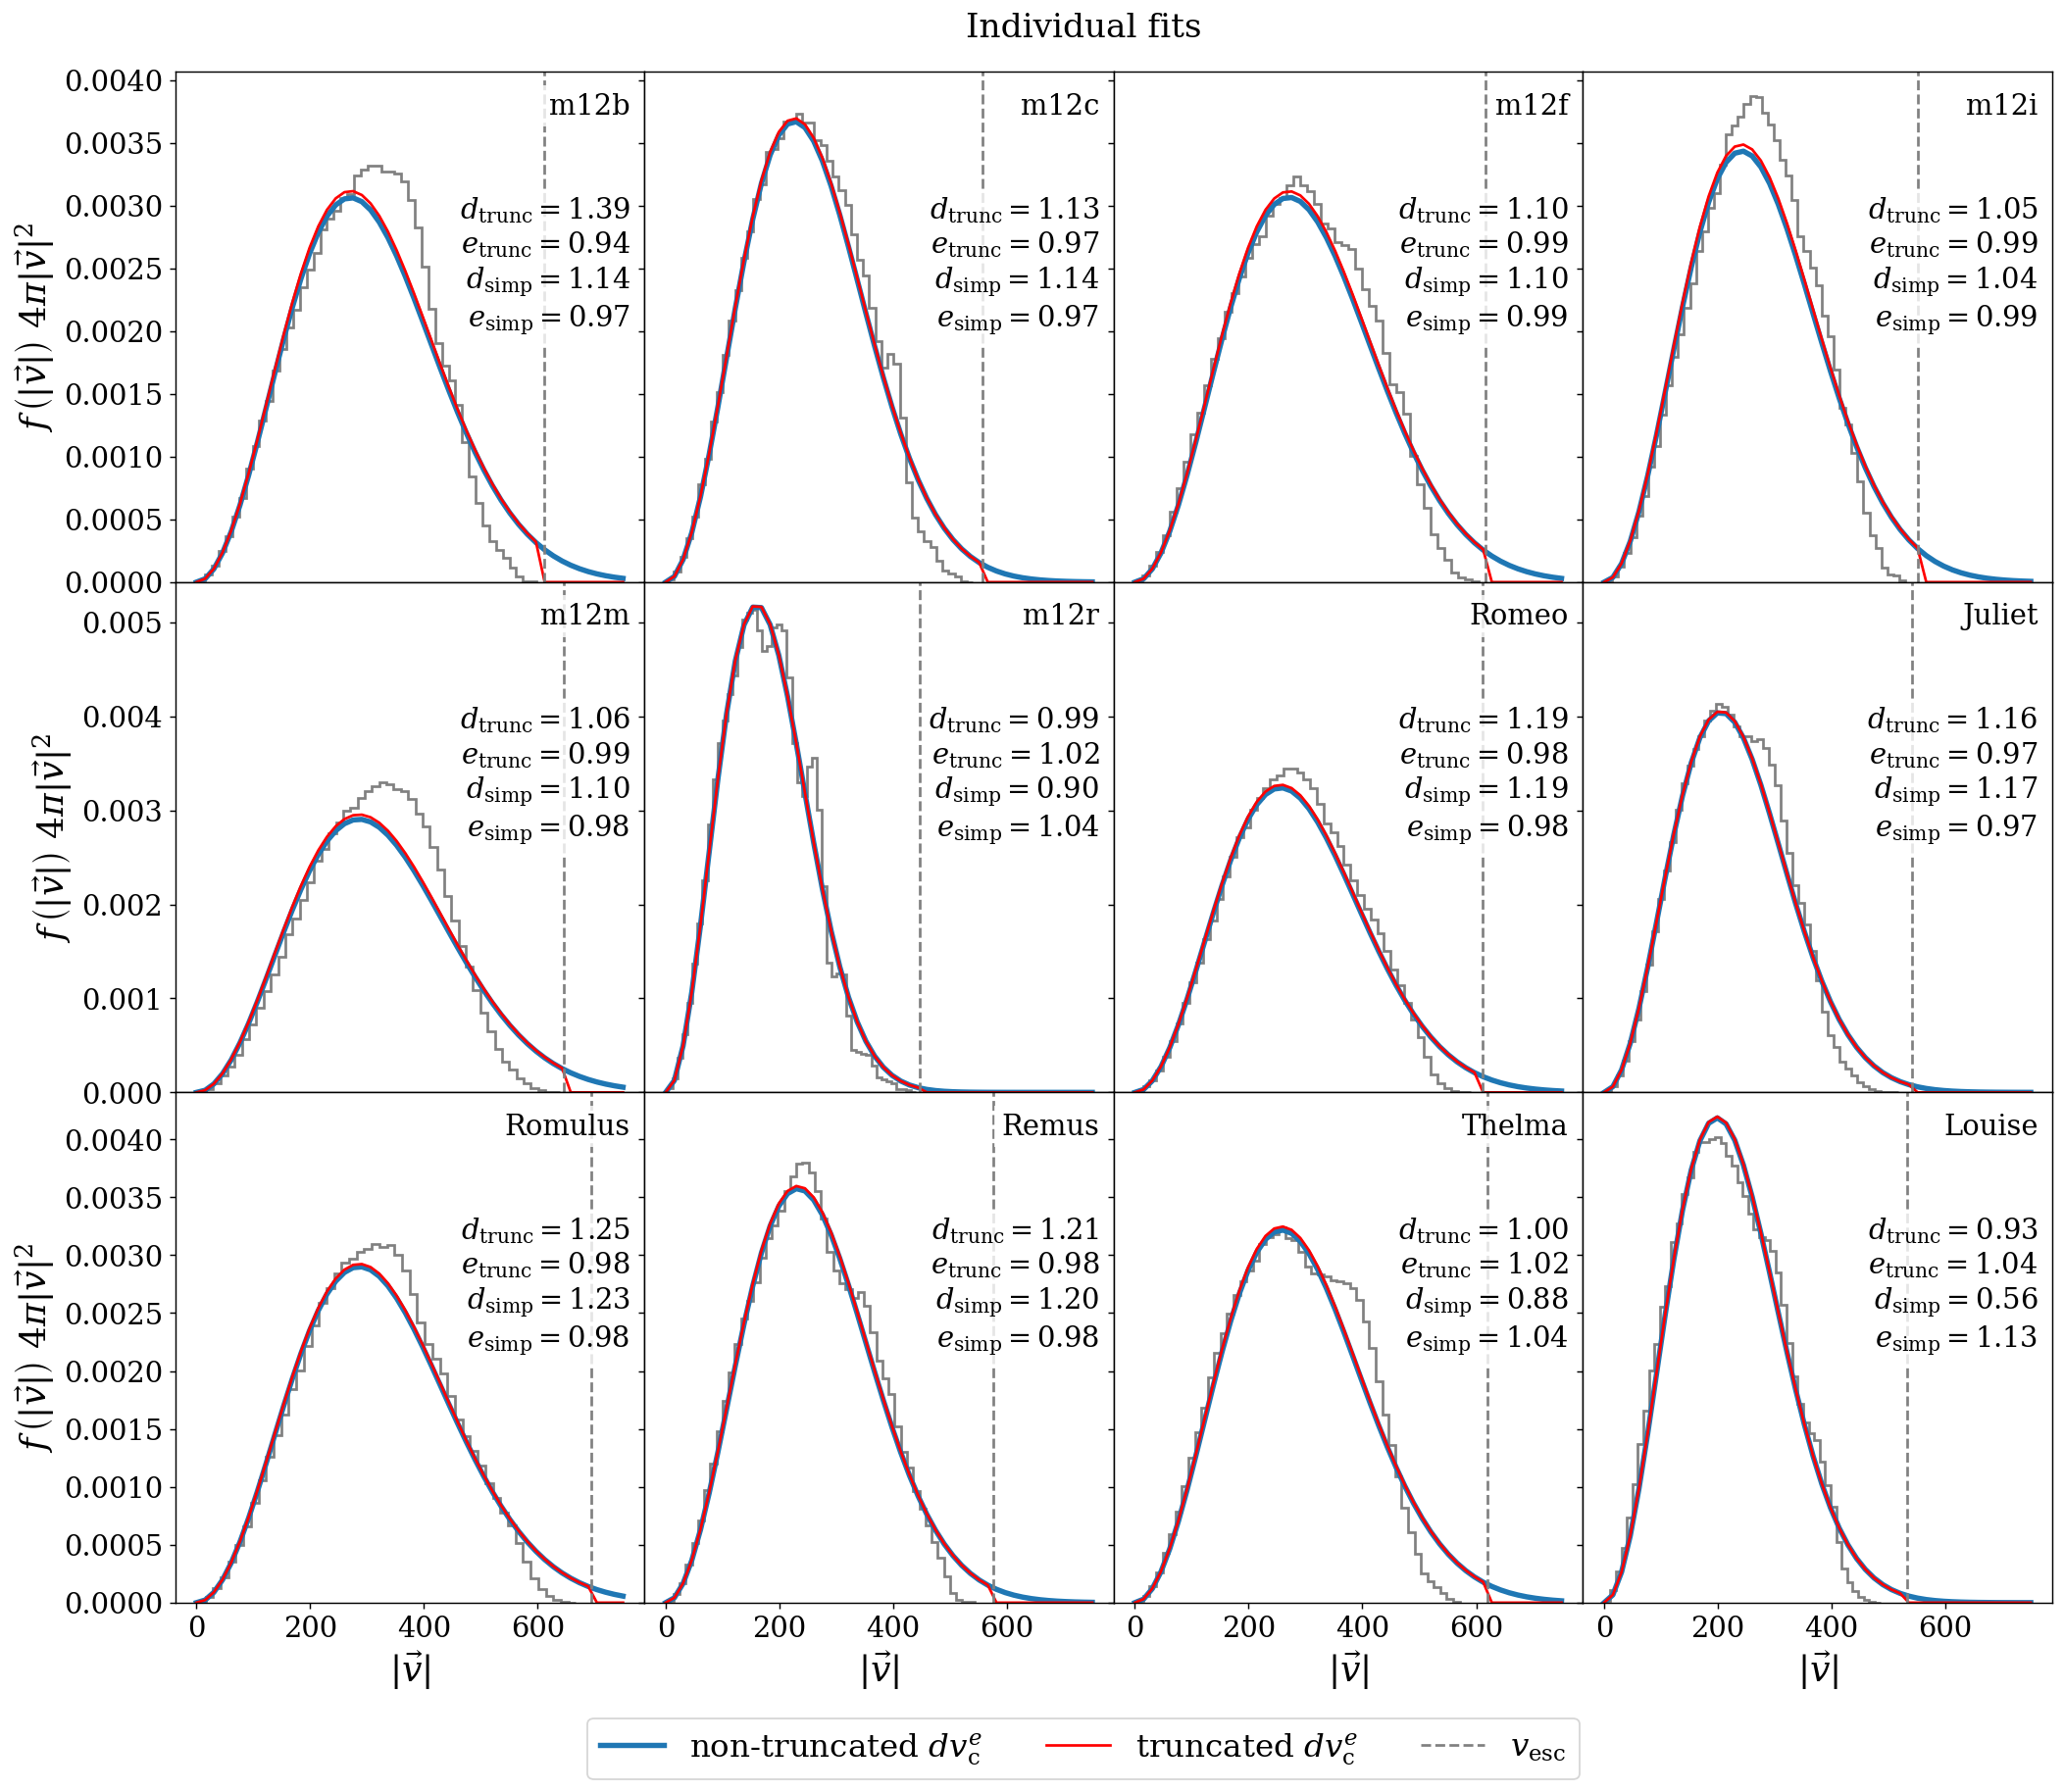

In [7]:
def fit_separate():
    df = dm_den.load_data('dm_stats_20221208.h5').drop(['m12w', 'm12z'])
    
    fig, axs = plt.subplots(3,4, figsize=(19., 12.*1.3), sharey='row',
                             sharex=True, dpi=130.)
    axs = axs.ravel()
    fig.subplots_adjust(wspace=0., hspace=0.)

    for i, gal in enumerate(df.index):
        gal_dict = pdfs_v[gal]
        bins = gal_dict['bins']
        vs_truth = (bins[1:] + bins[:-1]) / 2.
        vs_postfit = np.linspace(0., 750., len(vs_truth))
        # The reason I use len(vs_truth) above is because the X's I feed into
        # the distributions functions are len(vs_truth). It would be a pain to
        # make new X's.
        fs_truth = gal_dict['ps']
        vc = np.repeat(df.loc[gal, 'v_dot_phihat_disc(T<=1e4)'],
                       len(vs_truth)).astype(np.float64)
        #sigma_prediction = np.repeat(predict_sigma(vc), 
        #                             len(vs_truth)).astype(np.float64)
        sigma_prediction = predict_sigma(vc)
        # np.float64 is necessary because scipy.special.gammaincc can't handle
        # np.float128
        vesc = np.repeat(vesc_dict[gal]['ve_avg'], len(vs_truth)).astype(np.float64)
             
        ########################################################################
        # Fit d, e in d*v_c^e without truncation ###############################
        # "nt" stands for "not truncated"
        X_vc_nt = [vs_truth, vc]
        res_vc_nt, _ = scipy.optimize.curve_fit(max_d_e, X_vc_nt, fs_truth)
        axs[i].plot(vs_postfit, max_d_e([vs_postfit, *X_vc_nt[1:]], 
                                        *res_vc_nt),
                    label='non-truncated $dv_\mathrm{c}^e$',
                    lw=3.)
        ########################################################################
        
        ########################################################################
        # Fit d, e in d*v_c^3 with truncation ##################################
        X_vc_trunc = [vs_truth, vc, vesc]
        res_vc_trunc, _ = scipy.optimize.curve_fit(trunc_max_d_e, X_vc_trunc,
                                                   fs_truth)
        axs[i].plot(vs_postfit, trunc_max_d_e([vs_postfit, *X_vc_trunc[1:]],
                                              *res_vc_nt),
                    label='truncated $dv_\mathrm{c}^e$', ls='-', c='r')
        ########################################################################
        
        axs[i].stairs(fs_truth, bins, color='grey', lw=1.5)
        axs[i].axvline(vesc_dict[gal]['ve_avg'], color='grey', ls='--',
                       label='$v_\mathrm{esc}$')
        axs[i].grid()
        loc = np.array([0.97,0.96])
        kwargs_txt = dict(fontsize=16., xycoords='axes fraction',
              va='top', ha='right', 
              bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        axs[i].annotate(gal,loc,
                        **kwargs_txt)
        axs[i].annotate('$d_\mathrm{{trunc}}={0:0.2f}$\n'
                        '$e_\mathrm{{trunc}}={1:0.2f}$\n'
                        '$d_\mathrm{{simp}}={2:0.2f}$\n'
                        '$e_\mathrm{{simp}}={3:0.2f}$'.format(*res_vc_trunc,
                                                            *res_vc_nt),
                        loc - np.array([0., 0.2]),
                **kwargs_txt)
        
    for i in [0,4,8]:
        axs[i].set_ylabel('$f\,\left(|\\vec{v}|\\right)\ 4\pi|\\vec{v}|^2$')
    for ax in axs[-4:]:
        ax.set_xlabel('$|\\vec{v}|$')
    fig.suptitle('Universal fit', fontsize=19., y=0.91)

    axs[-2].legend(loc='upper center', bbox_to_anchor=(0.5, 0.06),
                   bbox_transform=fig.transFigure, ncol=3)
    fig.suptitle('Individual fits', fontsize=19., y=0.91)
    plt.show()
    return None
        
fit_separate()

## Finding a generalized $d$ for all galaxies at once

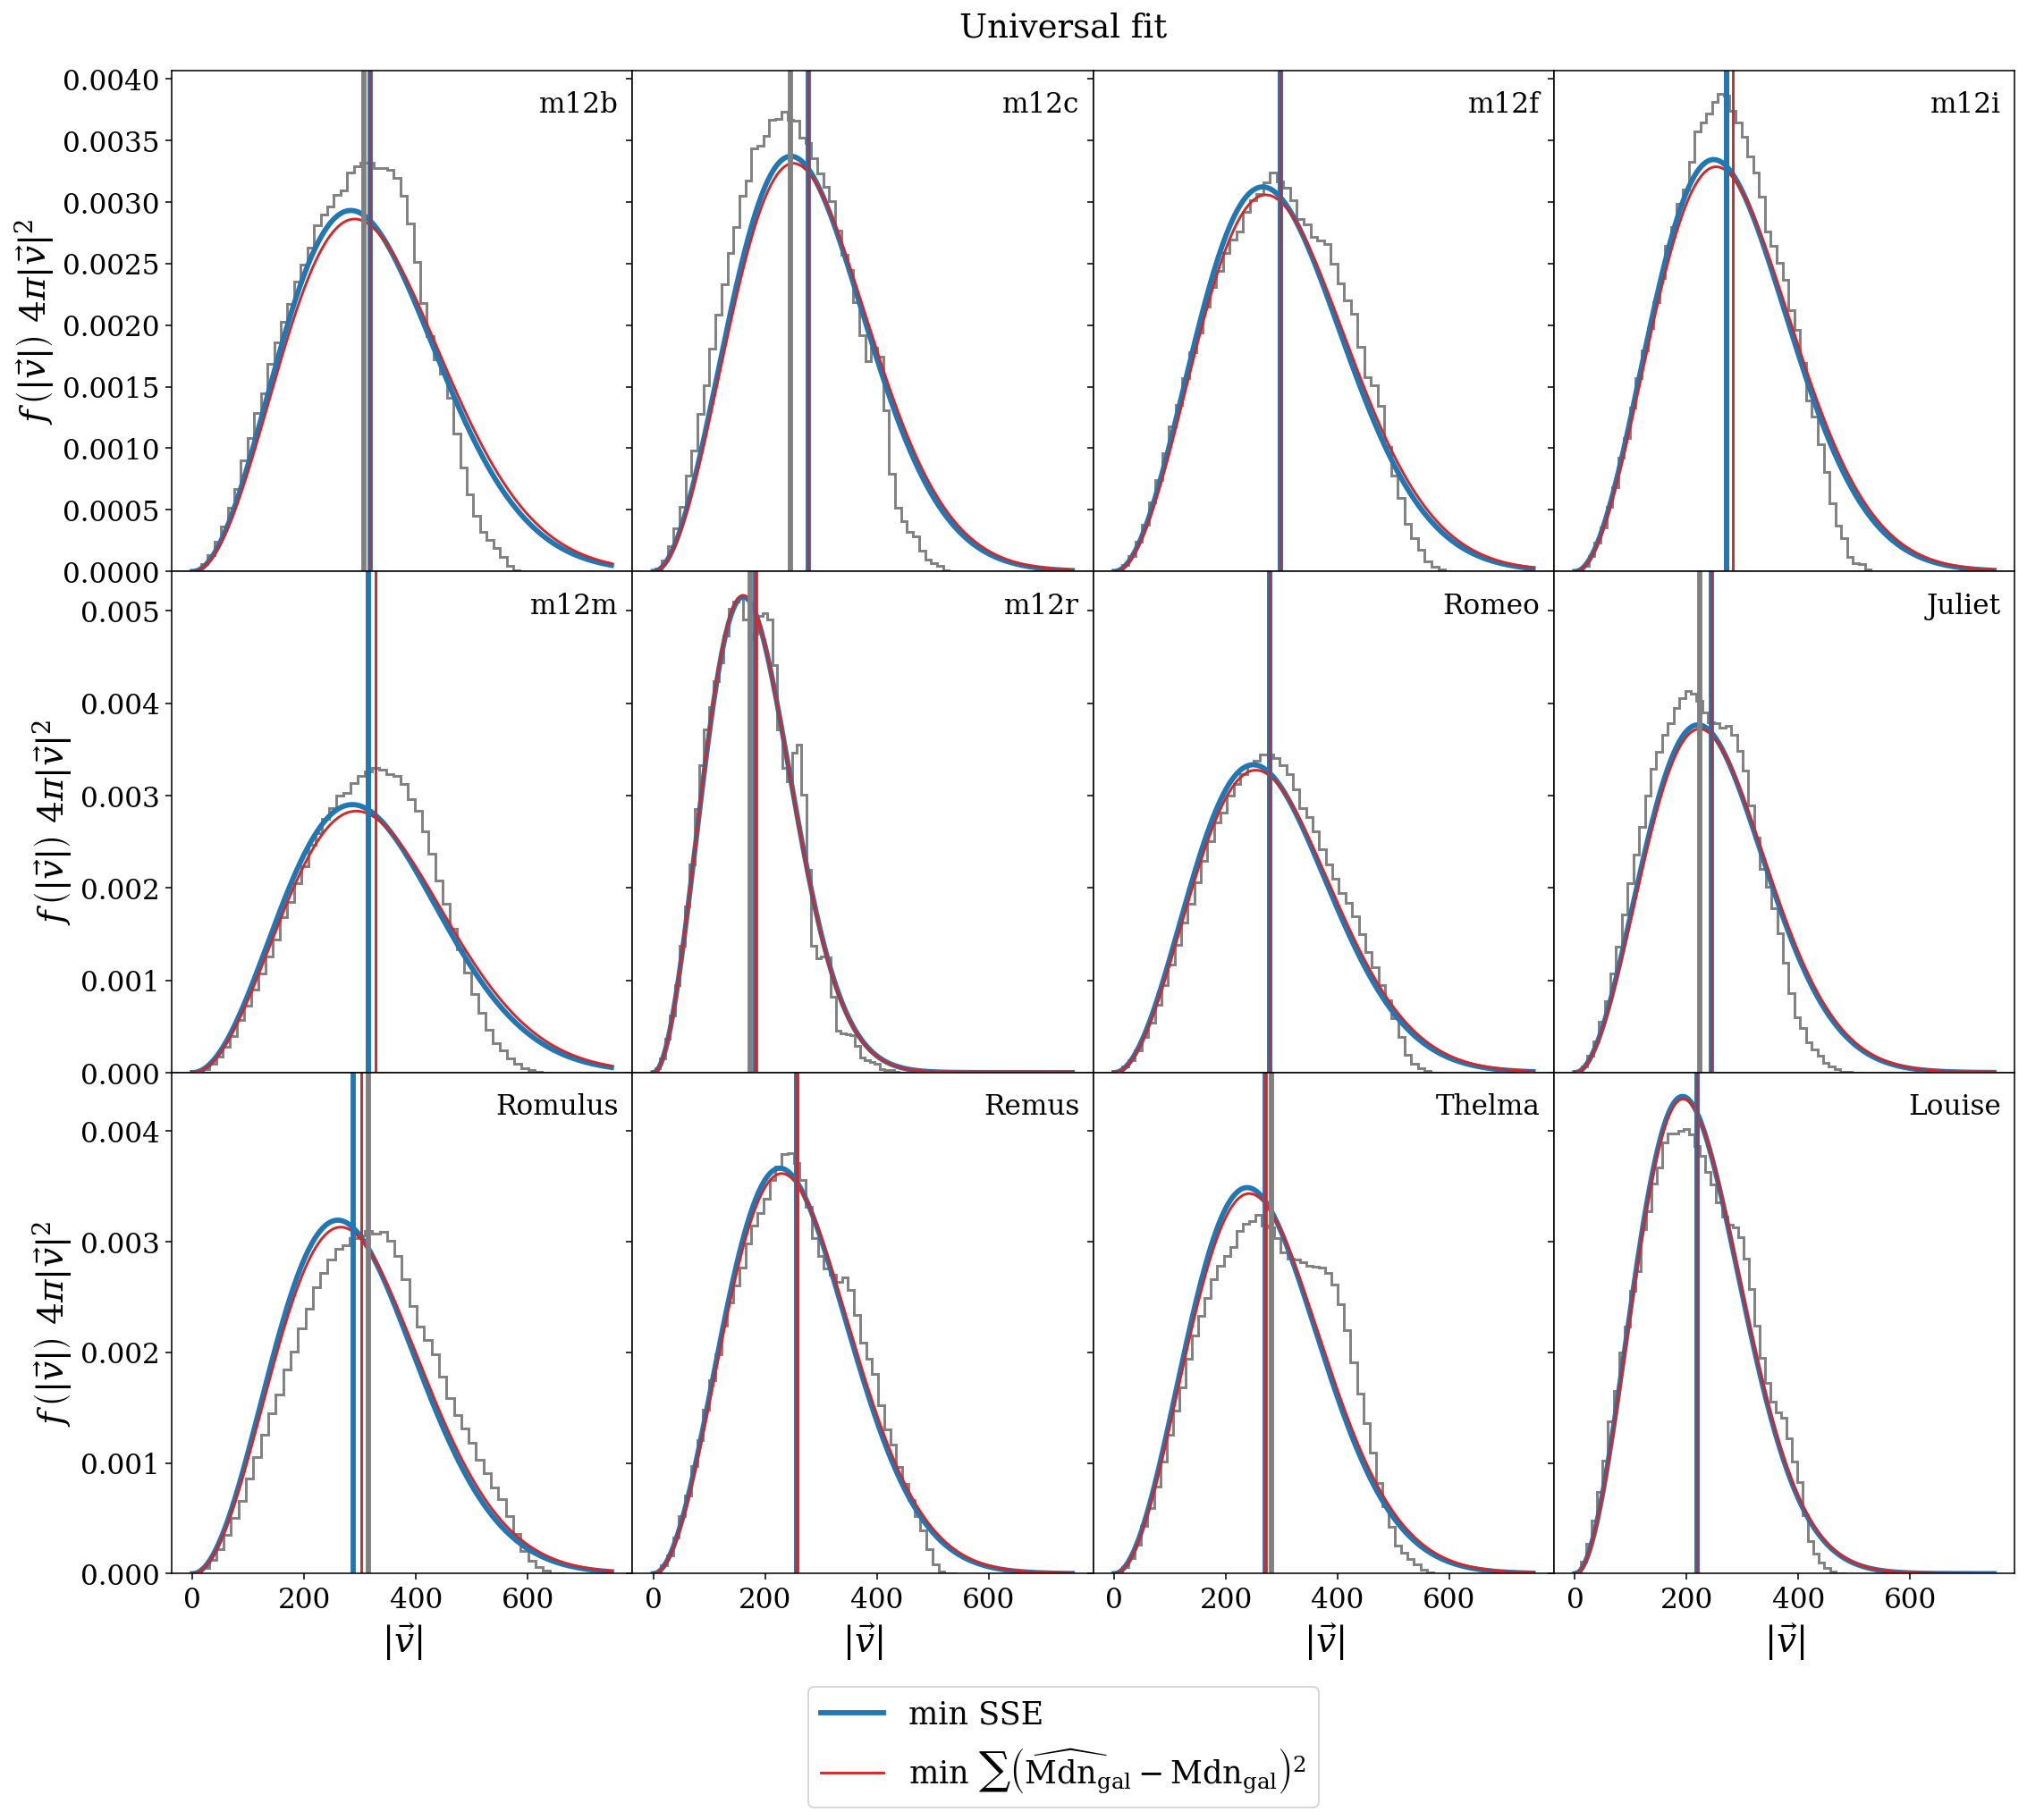

In [8]:
def fit_general():
    df = dm_den.load_data('dm_stats_20221208.h5')
    pdfs = pdfs_v.copy()
    pdfs.pop('m12z')
    pdfs.pop('m12w')

    for gal in pdfs:
        dict_gal = pdfs[gal]
        dict_gal['v0'] = np.repeat(
            dm_den.load_data('dm_stats_20221208.h5').loc[gal,'v0'],
            len(dict_gal['ps']))
        bins = dict_gal['bins']
        dict_gal['vs'] = (bins[1:] + bins[:-1]) / 2.
        dict_gal['vcirc'] = np.repeat(
            df.loc[gal, 'v_dot_phihat_disc(T<=1e4)'],
            len(dict_gal['ps']))

    fs = np.array([pdfs[galname]['ps'] 
                   for galname in pdfs]).flatten()
    vs = np.array([pdfs[galname]['vs'] 
                   for galname in pdfs]).flatten()
    vs_postfit = np.linspace(0., 750., 300)
    v0s = np.array([pdfs[galname]['v0'] 
                         for galname in pdfs]).flatten()
    vcircs = np.array([pdfs[galname]['vcirc'] 
                         for galname in pdfs]).flatten()
    sigmas_pred = predict_sigma(vcircs)

    X = [vs, vcircs]
    
    res_d, _ = scipy.optimize.curve_fit(max_d, X, fs, p0=[0.86])
    res_de, _ = scipy.optimize.curve_fit(max_d_e, X, fs, p0=[0.86, 1.])
    res_b, _ = scipy.optimize.curve_fit(max_scaled_sigma_for_fit, 
                                        [vs, sigmas_pred],
                                        fs)
    res_de_median = scipy.optimize.basinhopping(
        median_diff, 
        x0=[2.20596096, 0.8639135],                              
        #minimizer_kwargs={'method':'Powell'},
        niter=5
        )
    if res_de_median.fun <= 2388.491483707818:
        print('NEW BEST MEDIAN FIT')
        print(res_de_median)

    fig,axs=plt.subplots(3,4,figsize=(19.,12.*1.3), sharey='row',
                         sharex=True, dpi=140)
    axs=axs.ravel()
    fig.subplots_adjust(wspace=0.,hspace=0.)

    sse_sigma = 0.
    sse_scaled_vcirc = 0.
    sse_vcirc = 0.
    sse_v0_fit = 0.
    sse_med = 0.

    for i,galname in enumerate(pdfs):
        bins = pdfs_v[galname]['bins']
        vs_gal = (bins[1:] + bins[:-1]) / 2.
        f_at_vs = pdfs_v[galname]['ps']

        axs[i].stairs(f_at_vs,
                      bins, 
                      color='gray', lw=1.5)
        loc=[0.97,0.96]
        kwargs_txt = dict(fontsize=16., xycoords='axes fraction',
                      va='top', ha='right', 
                      bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        axs[i].annotate(galname,loc,
                        **kwargs_txt)

        vcirc = df.loc[galname,'v_dot_phihat_disc(T<=1e4)']

        # scaled v_circ ########################################################
        #d = 2.69290555
        #e = 0.82435569
        d, e = res_de
        v0_prediction = d*vcirc**e
        ys_pred_v0 = gen_max(vs_gal, v0_prediction, 1.)
        ys_pred_v0_plot = gen_max(vs_postfit, v0_prediction, 1.)        
        axs[i].plot(
                vs_postfit, ys_pred_v0_plot, 
                c='#1f77b4', 
                ls='-',
                label='min SSE',
                lw=3.)
        ########################################################################

        # getting the median right #############################################
        d_med, e_med = res_de_median.x
        ys_pred_med_fit = gen_max(vs_gal, 
                                  d_med*vcirc**e_med, 
                                  1.)
        ys_pred_med_fit_plot = gen_max(vs_postfit,
                                       d_med*vcirc**e_med,
                                       1.)
        axs[i].plot(vs_postfit, ys_pred_med_fit_plot, 
                    c='#d62728',
                    label='min $\sum\left(\mathrm{\widehat{Mdn}_{gal}'\
                          '-Mdn_{gal}}\\right)^2$')
        ########################################################################

        median_truth = get_medians(np.array([f_at_vs]), 
                                   np.array([vs_gal])).flatten()
        median_median_fit = get_medians(np.array([ys_pred_med_fit]), 
                                        np.array([vs_gal]))
        median_v0_fit = get_medians(np.array([ys_pred_v0]), np.array([vs_gal]))
        axs[i].axvline(median_truth, color='grey', lw=3.)
        axs[i].axvline(median_v0_fit, color='#1f77b4', lw=3.)
        axs[i].axvline(median_median_fit, color='#d62728')
        axs[i].grid()

        if galname in ['m12w', 'm12z']:
            pass
        else:
            sse_scaled_vcirc += np.sum((ys_pred_v0 - f_at_vs)**2.)
            sse_med += np.sum((ys_pred_med_fit - f_at_vs)**2.)

    axs[-2].legend(loc='upper center', bbox_to_anchor=(0.5, 0.06),
                   bbox_transform=fig.transFigure)
    for i in [0,4,8]:
        axs[i].set_ylabel('$f\,\left(|\\vec{v}|\\right)\ 4\pi|\\vec{v}|^2$')
    for ax in axs[-4:]:
        ax.set_xlabel('$|\\vec{v}|$')
    fig.suptitle('Universal fit', fontsize=19., y=0.91)
    
    plt.show()
        
    return None

fit_general()

## Checking $g(v_\mathrm{min})$

### Individual fits

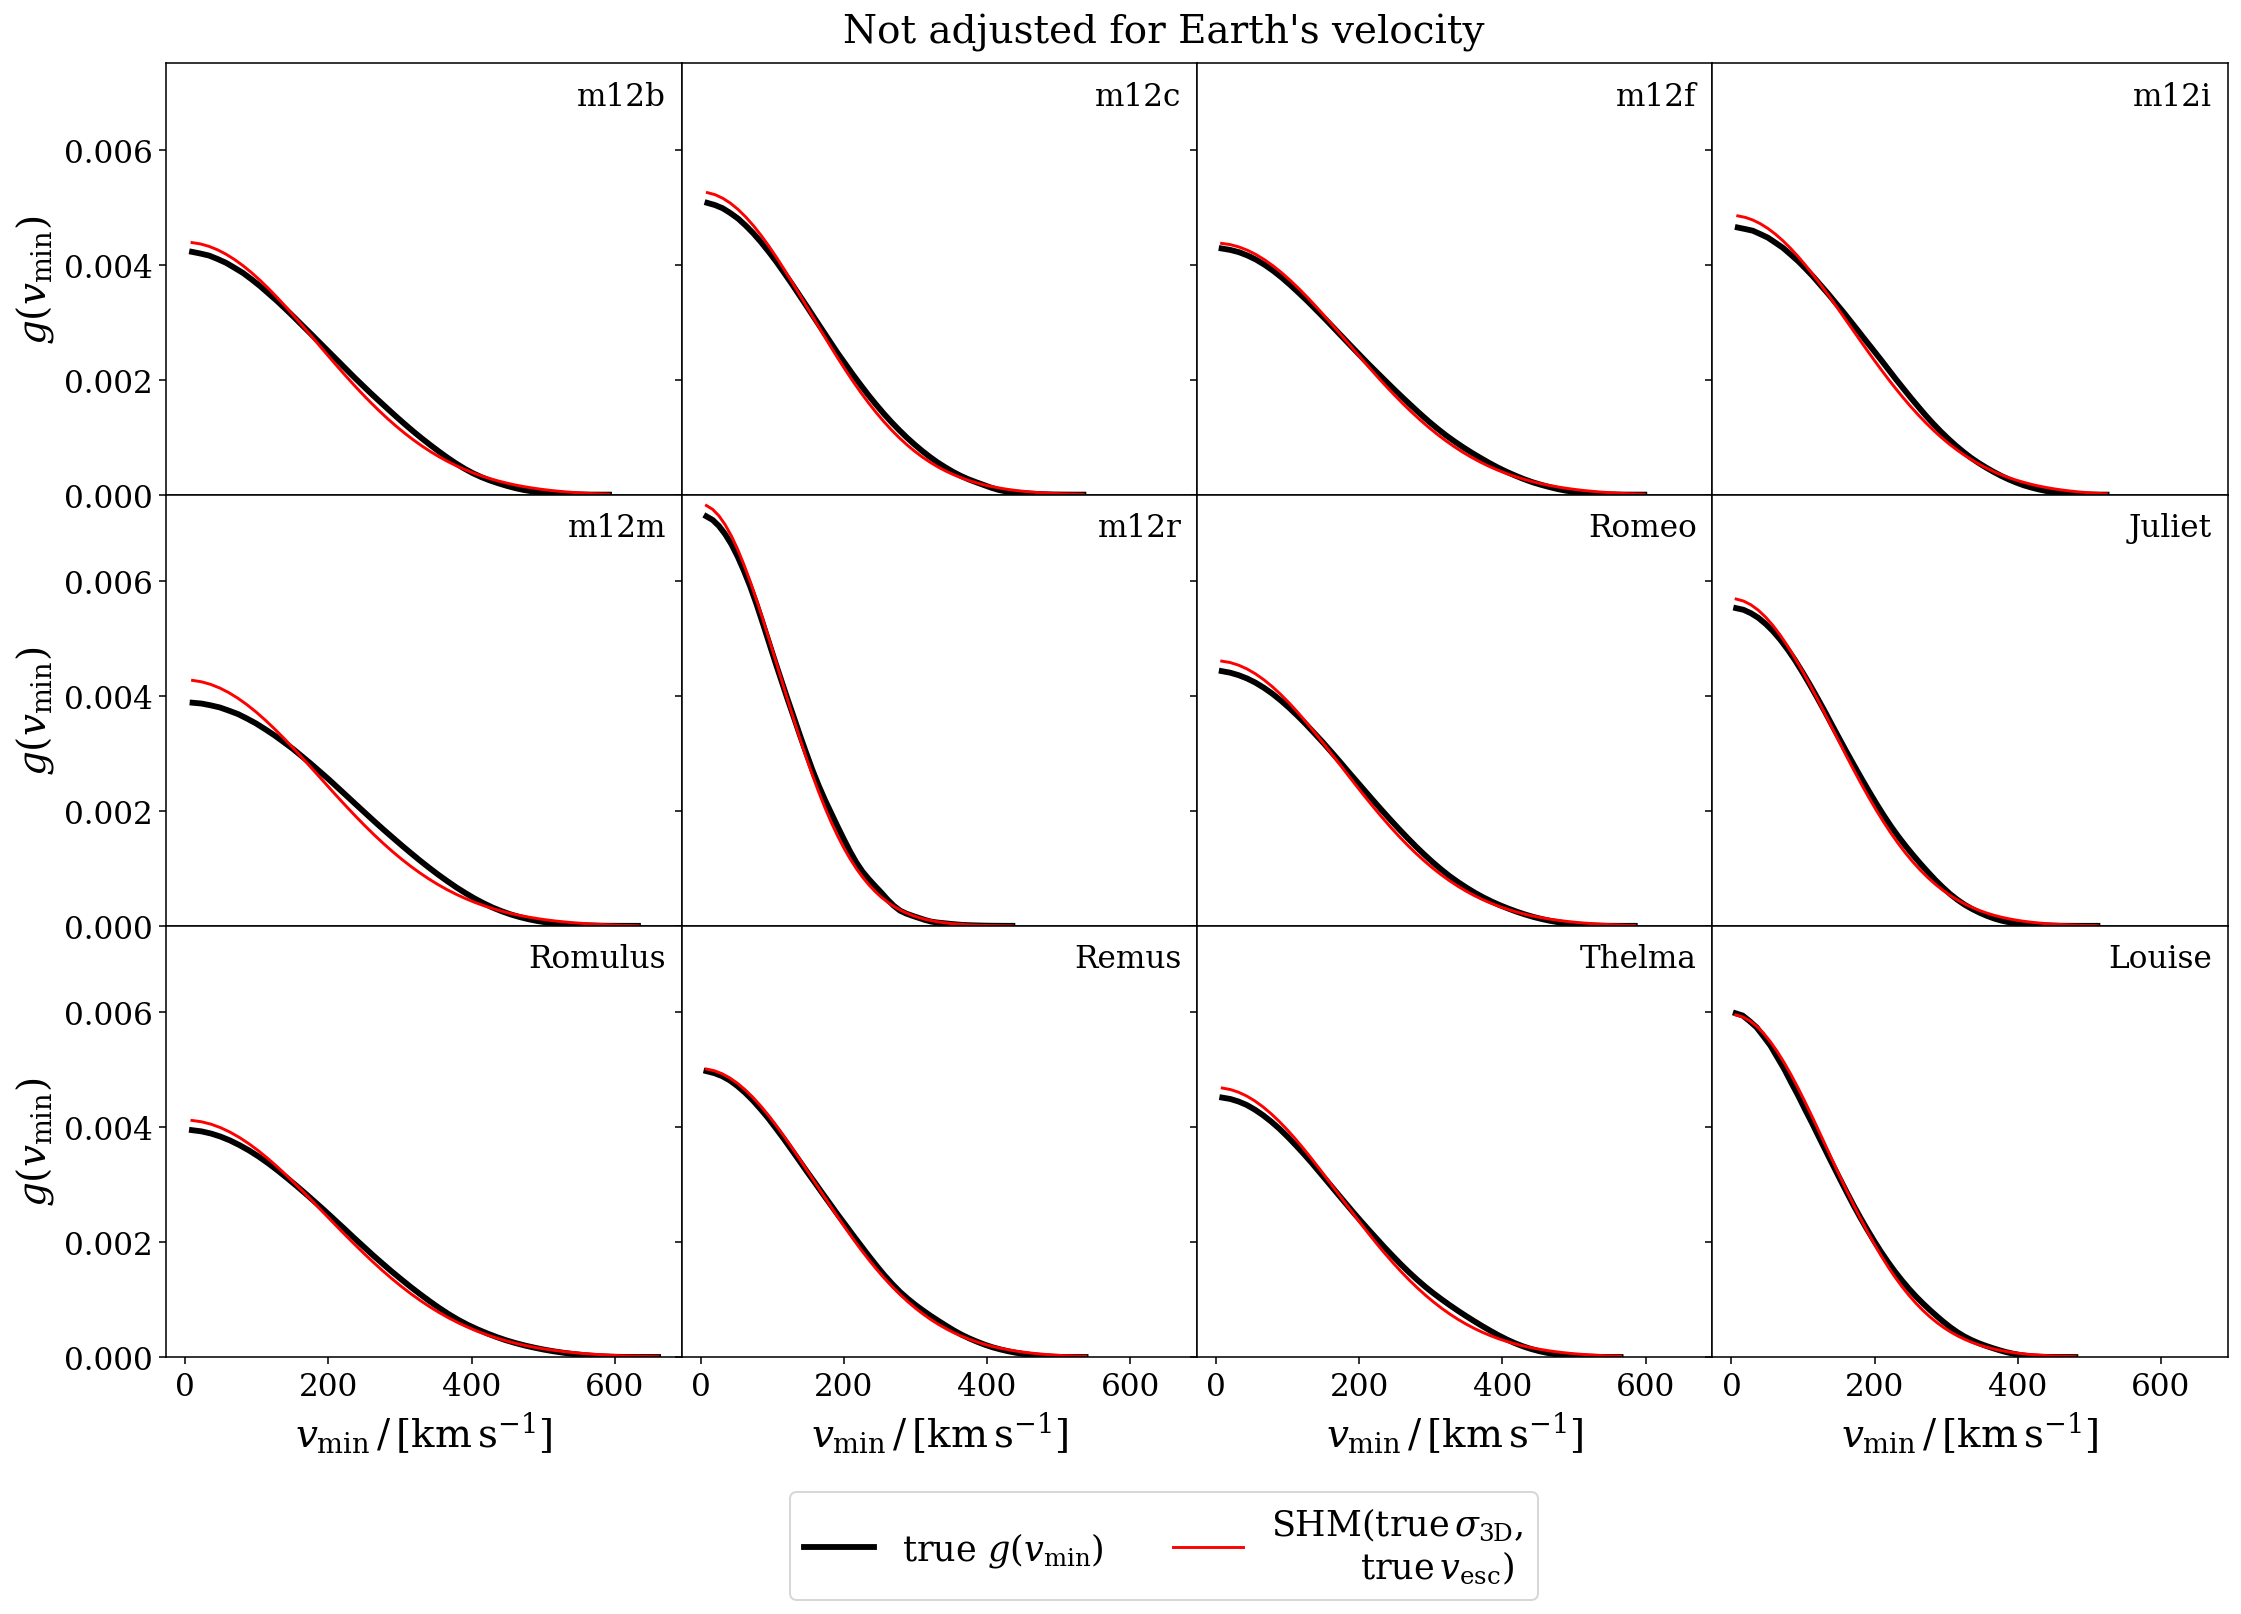

In [9]:
def plot_g_indv():
    df = dm_den.load_data('dm_stats_20221208.h5')
    pdfs = pdfs_v.copy()
    pdfs.pop('m12z')
    pdfs.pop('m12w')
    
    fig,axs=plt.subplots(3,4,figsize=(19.,12.), sharex=True, sharey=True,
                         dpi=140)
    axs=axs.ravel()
    fig.subplots_adjust(wspace=0.,hspace=0.)
    
    for i, gal in enumerate(pdfs):
        dict_gal = pdfs[gal]
        vs_truth = dict_gal['vs']
        ps_truth = dict_gal['ps']
        vc = df.loc[gal, 'v_dot_phihat_disc(T<=1e4)']
        vc_forfit = np.repeat(vc, len(vs_truth)).astype(np.float64)
        vesc = vesc_dict[gal]['ve_avg']
        vesc_forfit = np.repeat(vesc, len(vs_truth)).astype(np.float64)
        sigma_truth = df.loc[gal, 'disp_dm_disc_cyl']
        
        X = [vs_truth, vc, vesc]
        
        # p(vmin) = 4pi v^2 f(v)
        # g(vmin) = int f(v)/v (4pi v^2 dv) 
        #         = int p(v) / (4pi v^2) v^2/v 4pi dv
        #         = int p(v)/v dv
        integrand_truth = ps_truth / vs_truth
        gs_truth = [scipy.integrate.simps(integrand_truth[i:], vs_truth[i:]) 
                    for i in range(len(integrand_truth))]
        gs_truth = np.array(gs_truth)
        
        axs[i].plot(vs_truth, gs_truth, c='k', lw=3., 
                    label='true $g(v_\mathrm{min})$')
        '''
        X = [vs_truth, vc_forfit, vesc_forfit]
        res_de, _ = scipy.optimize.curve_fit(trunc_max_d_e, X, ps_truth, 
                                             p0=[0.86, 1.])
        d, e = res_de
        v0_prediction_de = d*vc**e
        gs_prediction_de = g_trunc_max_simple(vs_truth, v0_prediction_de, vesc)
        axs[i].plot(vs_truth, gs_prediction_de, label='$v_0=dv_\mathrm{c}^e$')
        '''
        v0_jeans = np.sqrt(2./3.) * sigma_truth
        gs_jeans = g_trunc_max_simple(vs_truth, v0_jeans, vesc)
        axs[i].plot(vs_truth, gs_jeans, 
                    #label='$v_0=\sqrt{\\frac{2}{3}}\sigma_\mathrm{3D}$')
                    label = 'SHM$(\mathrm{true}\,\sigma_\mathrm{{3D}}$'\
                            ',\n        '\
                            'true$\,v_\mathrm{{esc}})$',
                    c='red')
        
        loc=[0.97,0.96]
        kwargs_txt = dict(fontsize=16., xycoords='axes fraction',
                      va='top', ha='right', 
                      bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        axs[i].annotate(gal,loc,
                        **kwargs_txt)
        axs[i].set_ylim(0, 0.0075)
        axs[i].grid()
    for i in [0,4,8]:
        axs[i].set_ylabel('$g(v_\mathrm{min})$')
    for ax in axs[-4:]:
        ax.set_xlabel('$v_\mathrm{min}\,/\,\left[\mathrm{km\,s^{-1}}\\right]$')
    axs[-2].legend(loc='upper center', bbox_to_anchor=(0.5, 0.04),
                   bbox_transform=fig.transFigure, ncol=3)
    fig.suptitle('Not adjusted for Earth\'s velocity', fontsize=20., y=0.91)
    plt.show()
    return None
plot_g_indv()

### Universal fit

100% |####################################################################################################|


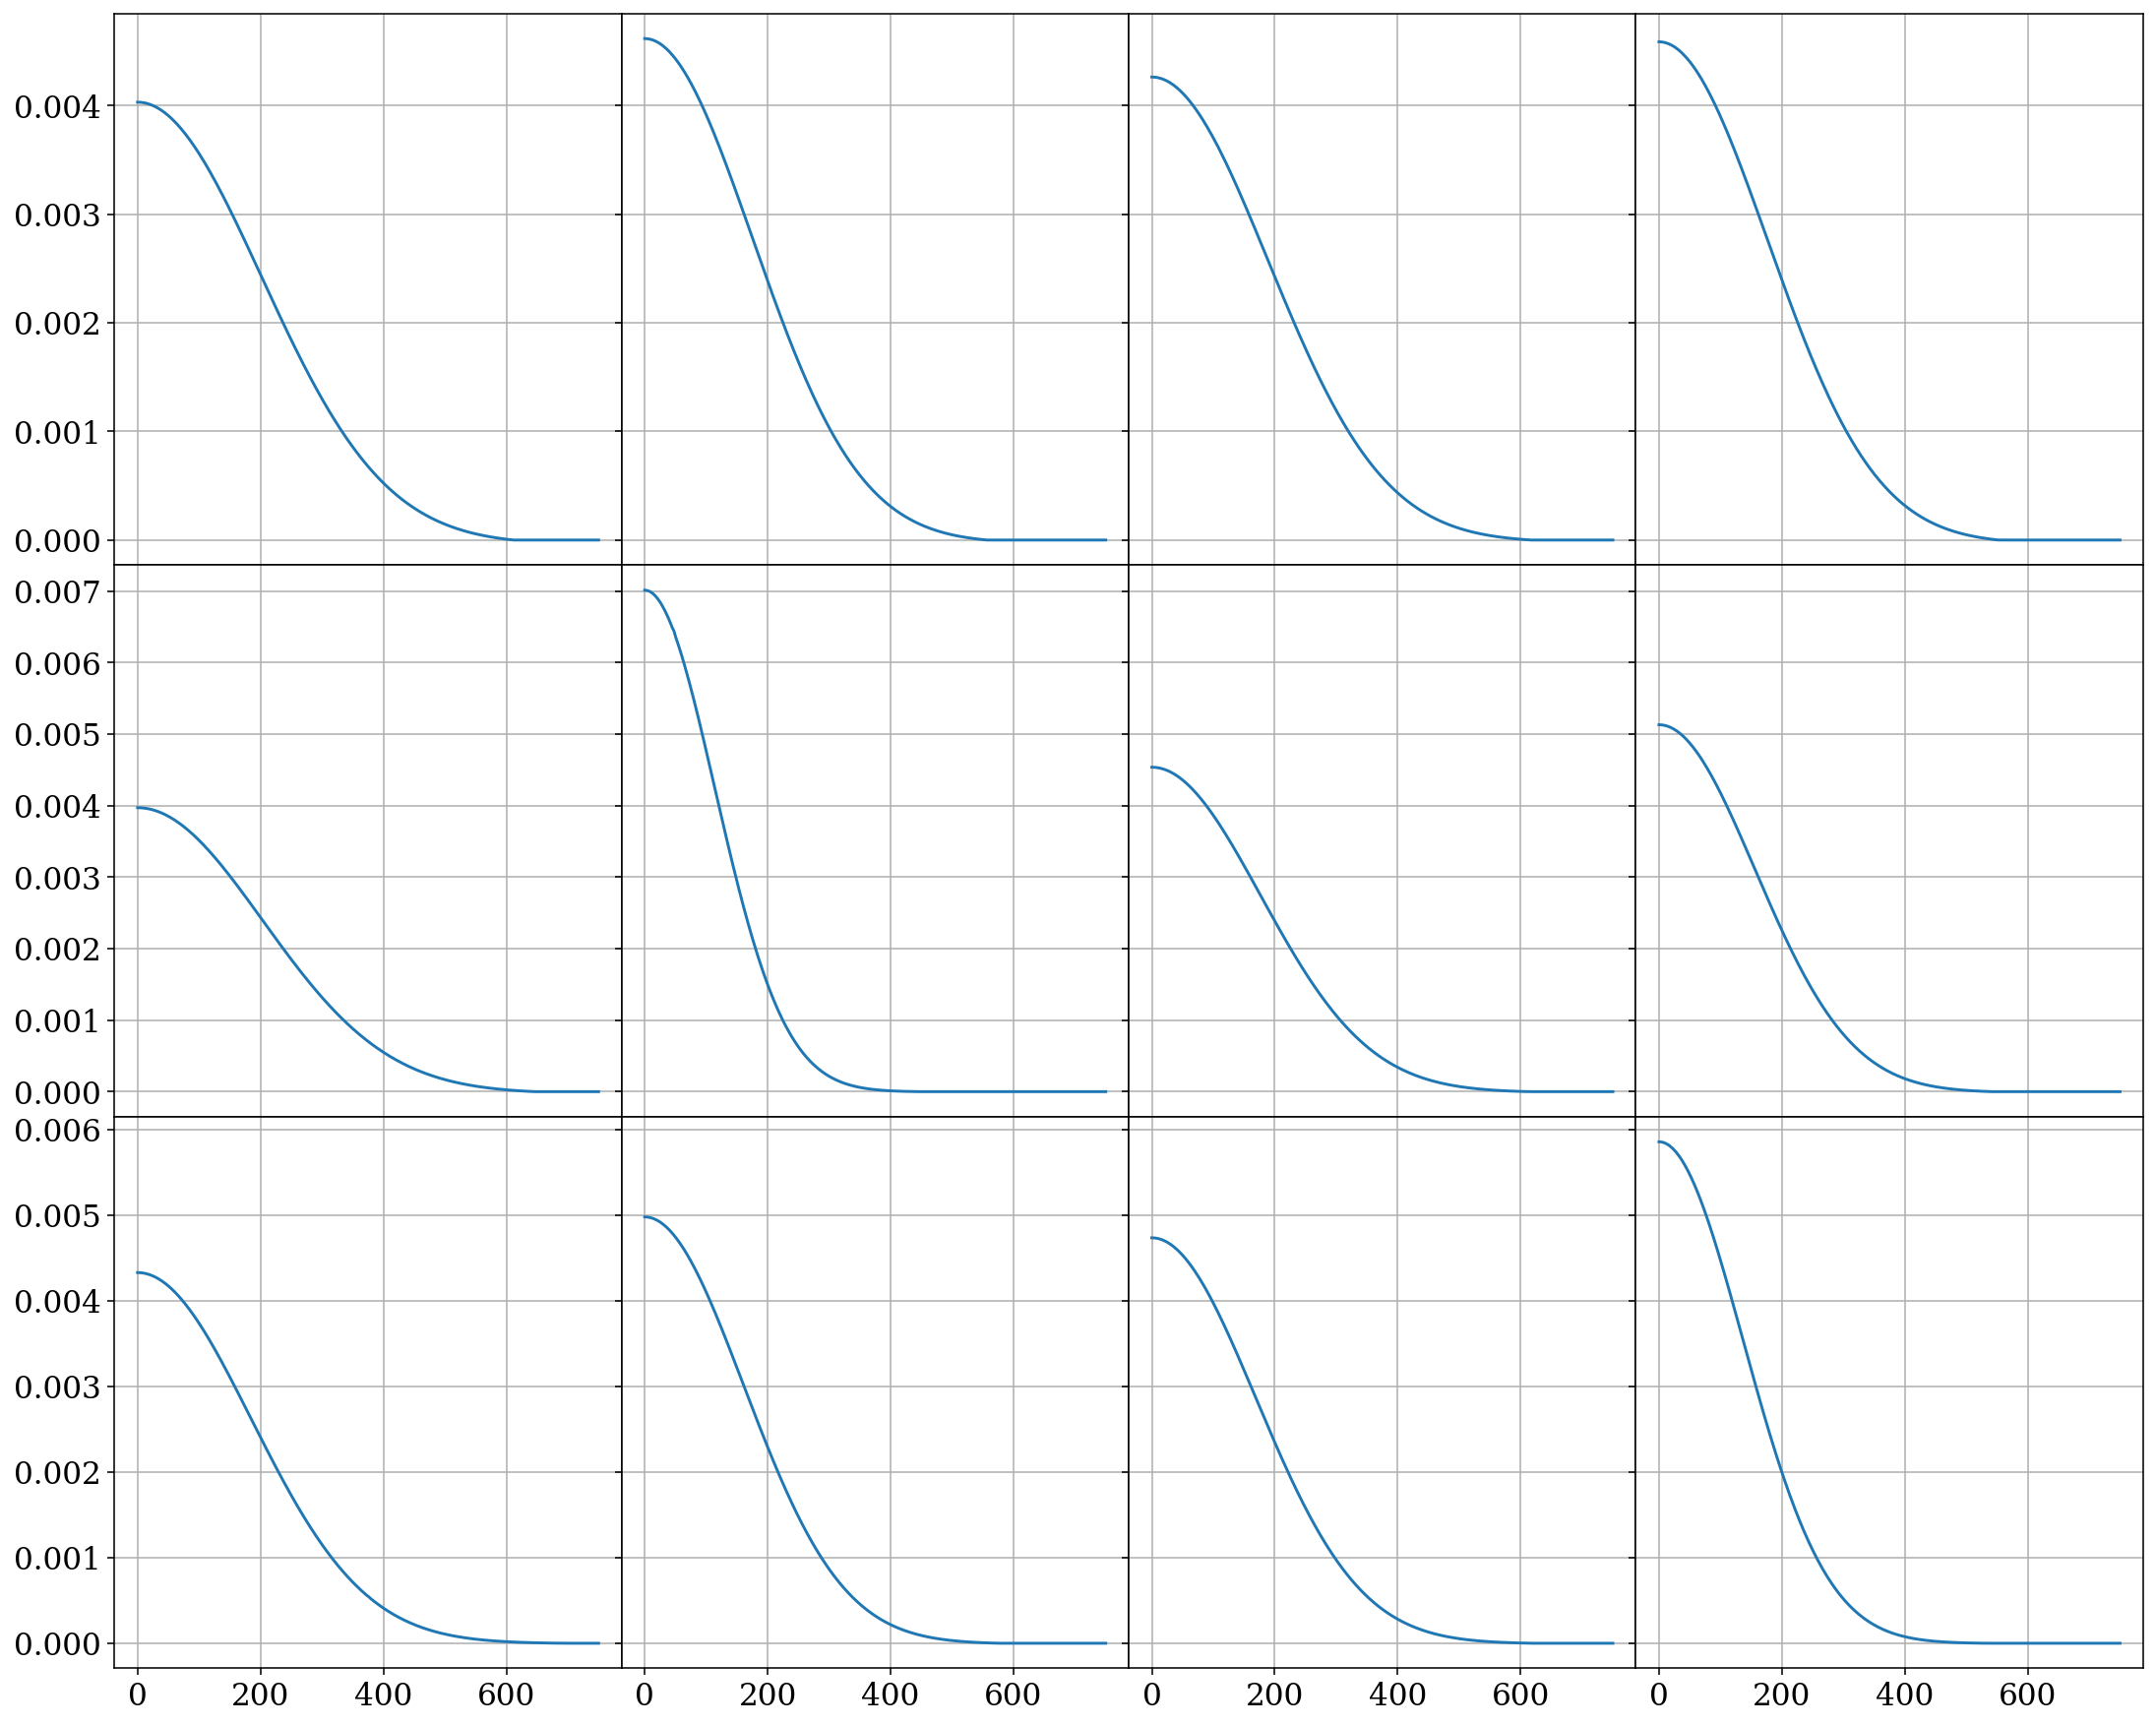

In [10]:
def plot_g_universal():
    df = dm_den.load_data('dm_stats_20221208.h5')
    pdfs = pdfs_v.copy()
    pdfs.pop('m12z')
    pdfs.pop('m12w')

    for gal in pdfs:
        dict_gal = pdfs[gal]
        dict_gal['v0'] = np.repeat(
            dm_den.load_data('dm_stats_20221208.h5').loc[gal,'v0'],
            len(dict_gal['ps']))
        bins = dict_gal['bins']
        dict_gal['vs'] = (bins[1:] + bins[:-1]) / 2.
        dict_gal['vcirc'] = np.repeat(
            df.loc[gal, 'v_dot_phihat_disc(T<=1e4)'],
            len(dict_gal['ps'])).astype(np.float64)
        dict_gal['vesc'] = np.repeat(vesc_dict[gal]['ve_avg'],
                                     len(dict_gal['ps'])).astype(np.float64)
    
    ps = np.array([pdfs[galname]['ps'] 
                   for galname in pdfs]).flatten()
    vs = np.array([pdfs[galname]['vs'] 
                   for galname in pdfs]).flatten()
    vs_postfit = np.linspace(0., 750., 300)
    v0s = np.array([pdfs[galname]['v0'] 
                         for galname in pdfs]).flatten()
    vcircs = np.array([pdfs[galname]['vcirc'] 
                         for galname in pdfs]).flatten()
    # vescs = escape velocities
    vescs = np.array([pdfs[galname]['vesc'] 
                         for galname in pdfs]).flatten()
    X = [vs, vcircs, vescs]
    
    res_de, _ = scipy.optimize.curve_fit(trunc_max_d_e, X, ps, p0=[0.86, 1.])
    
    fig,axs=plt.subplots(3,4,figsize=(19.,12.*1.3), sharey='row',
                         sharex=True, dpi=140)
    axs=axs.ravel()
    fig.subplots_adjust(wspace=0.,hspace=0.)
    
    pbar = ProgressBar()
    for i, gal in enumerate(pbar(pdfs)):
        vcirc = df.loc[gal,'v_dot_phihat_disc(T<=1e4)']
        d, e = res_de
        v0_prediction_de = np.float64(d*vcirc**e)
        vesc = np.float64(vesc_dict[gal]['ve_avg'])
        gs_de = g_trunc_max_simple(vs_postfit, v0_prediction_de, vesc)
        axs[i].plot(vs_postfit, gs_de)
    plt.show()
        
plot_g_universal()

# Checking $f(\vec{v}-\vec{v}_\oplus)$ versus $f(\vec{v})$

/tmp/ipykernel_5165/3170528422.py:3: RuntimeWarning: overflow encountered in power
  N = 4./3.*np.pi * v0**3. * scipy.special.gamma(1.+3./(2.*a))
/tmp/ipykernel_5165/3170528422.py:38: RuntimeWarning: overflow encountered in power
  N = v0**3./2./a * (g1 - g2)
/tmp/ipykernel_5165/3170528422.py:38: RuntimeWarning: invalid value encountered in multiply
  N = v0**3./2./a * (g1 - g2)
/tmp/ipykernel_5165/3170528422.py:39: RuntimeWarning: divide by zero encountered in true_divide
  p = f/N


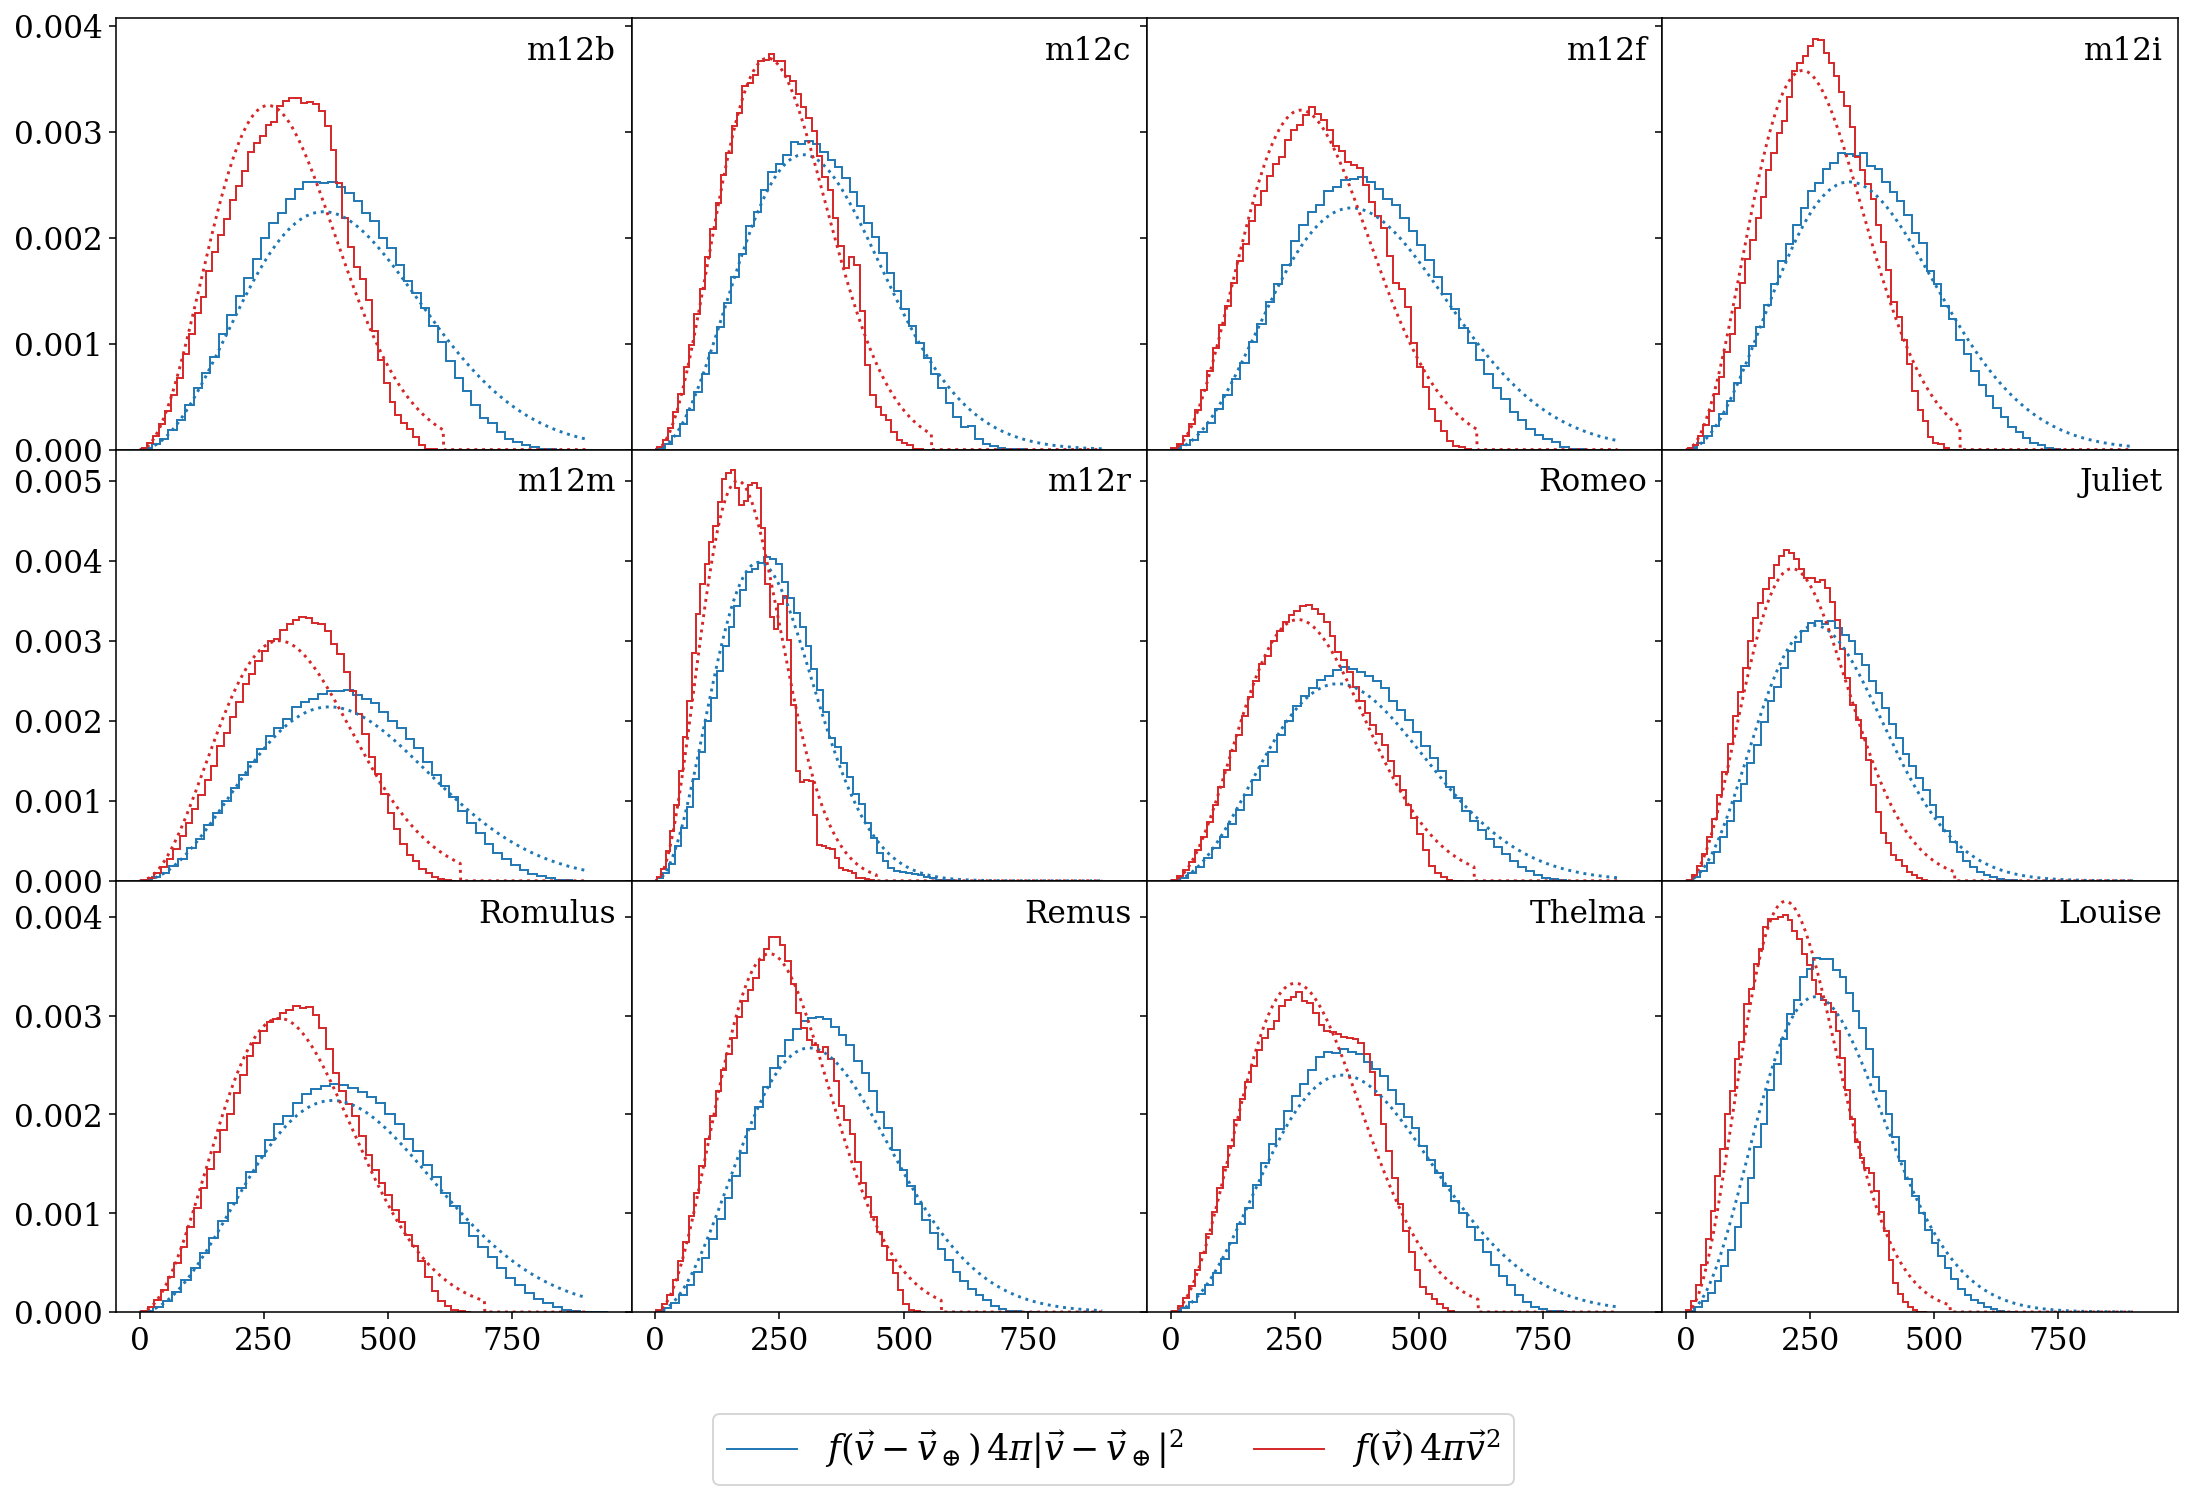

In [11]:
def compare_f():
    df = dm_den.load_data('dm_stats_20221208.h5').drop(['m12w', 'm12z'])
    
    fig,axs=plt.subplots(3,4,figsize=(19.,12.), sharey='row',
                         sharex=True, dpi=140)
    axs=axs.ravel()
    fig.subplots_adjust(wspace=0.,hspace=0.)

    for i, gal in enumerate(df.index):
        pdf_with_earth = pdfs_v_incl_vearth[gal]
        bins_with_earth = pdf_with_earth['bins']
        vs_with_earth = (bins_with_earth[1:] + bins_with_earth[:-1]) / 2.
        ps_truth_with_earth = pdf_with_earth['ps']
        
        pdf_no_earth = pdfs_v[gal]
        bins_no_earth = pdf_no_earth['bins']
        vs_no_earth = (bins_no_earth[1:] + bins_no_earth[:-1]) / 2.
        ps_truth_no_earth = pdf_no_earth['ps']
        
        vc = df.loc[gal, 'v_dot_phihat_disc(T<=1e4)']
        vesc = vesc_dict[gal]['ve_avg']  
        
        vs_postfit = np.linspace(0., 900., 1000)
        
        ########################################################################
        # Including Earth's velocity
        ########################################################################
        axs[i].stairs(pdf_with_earth['ps'], bins_with_earth,
                      label='$f(\\vec{v}-\\vec{v}_\oplus)'\
                            '\,4\pi|\\vec{v}-\\vec{v}_\oplus|^2$',
                      color='#1f77b4')
        X_with_earth = [vs_with_earth, 
                        np.repeat(vc, len(vs_with_earth))]
        res_with_earth, _ = scipy.optimize.curve_fit(max_d_e, 
                                                     X_with_earth, 
                                                     ps_truth_no_earth, 
                                                     p0=[0.86, 1.])      
        v0_prediction_with_earth = res_with_earth[0] * vc ** res_with_earth[1]
        axs[i].plot(vs_postfit, gen_max(vs_postfit,
                                        v0_prediction_with_earth,
                                        1.),
                    c='#1f77b4', ls=':')
        ########################################################################
        
        ########################################################################
        # Not adjusting for Earth's velocity
        ########################################################################
        axs[i].stairs(pdf_no_earth['ps'], bins_no_earth,
                      label='$f(\\vec{v})\,4\pi\\vec{v}^2$',
                      color='#d62728')
        X_no_earth = [vs_no_earth,
                      np.repeat(vc, len(vs_no_earth)),
                      np.repeat(vesc, len(vs_no_earth))]
        res_no_earth, _ = scipy.optimize.curve_fit(trunc_max_d_e,
                                                   X_no_earth,
                                                   ps_truth_with_earth,
                                                   p0=[0.86, 1.])
        v0_prediction_no_earth = res_no_earth[0] * vc ** res_no_earth[1]
        axs[i].plot(vs_postfit, trunc_max_simple(vs_postfit,
                                                 v0_prediction_no_earth,
                                                 vesc),
                    c='#d62728', ls=':')
        ########################################################################
       
        loc=[0.97,0.96]
        kwargs_txt = dict(fontsize=16., xycoords='axes fraction',
                      va='top', ha='right', 
                      bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        axs[i].annotate(gal,loc,
                        **kwargs_txt)
        axs[i].grid()
    axs[-2].legend(loc='upper center', bbox_to_anchor=(0.5, 0.06),
                   bbox_transform=fig.transFigure, ncol=3)
    plt.show()
    return None
compare_f()

# Fitting an escape velocity to the galaxies

## Fitting $v_\mathrm{esc}=hv_\mathrm{c}^j$

/tmp/ipykernel_18352/51415881.py:59: RuntimeWarning: overflow encountered in power
  vesc = h * vc ** j
/tmp/ipykernel_18352/3170528422.py:19: RuntimeWarning: invalid value encountered in multiply
  N2 = 2*vesc * np.exp( - vesc**2. / v0**2. )
/tmp/ipykernel_18352/3170528422.py:19: RuntimeWarning: overflow encountered in square
  N2 = 2*vesc * np.exp( - vesc**2. / v0**2. )
/tmp/ipykernel_18352/3170528422.py:20: RuntimeWarning: overflow encountered in square
  N = np.pi*v0**2. * (N1 - N2)
/tmp/ipykernel_18352/3170528422.py:20: RuntimeWarning: invalid value encountered in multiply
  N = np.pi*v0**2. * (N1 - N2)
/tmp/ipykernel_18352/3170528422.py:21: RuntimeWarning: overflow encountered in square
  f = np.exp( - v**2. / v0**2. )
/tmp/ipykernel_18352/3170528422.py:22: RuntimeWarning: divide by zero encountered in true_divide
  f /= N
/export/nfs0home/pstaudt/miniconda3/envs/dm_stats/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters

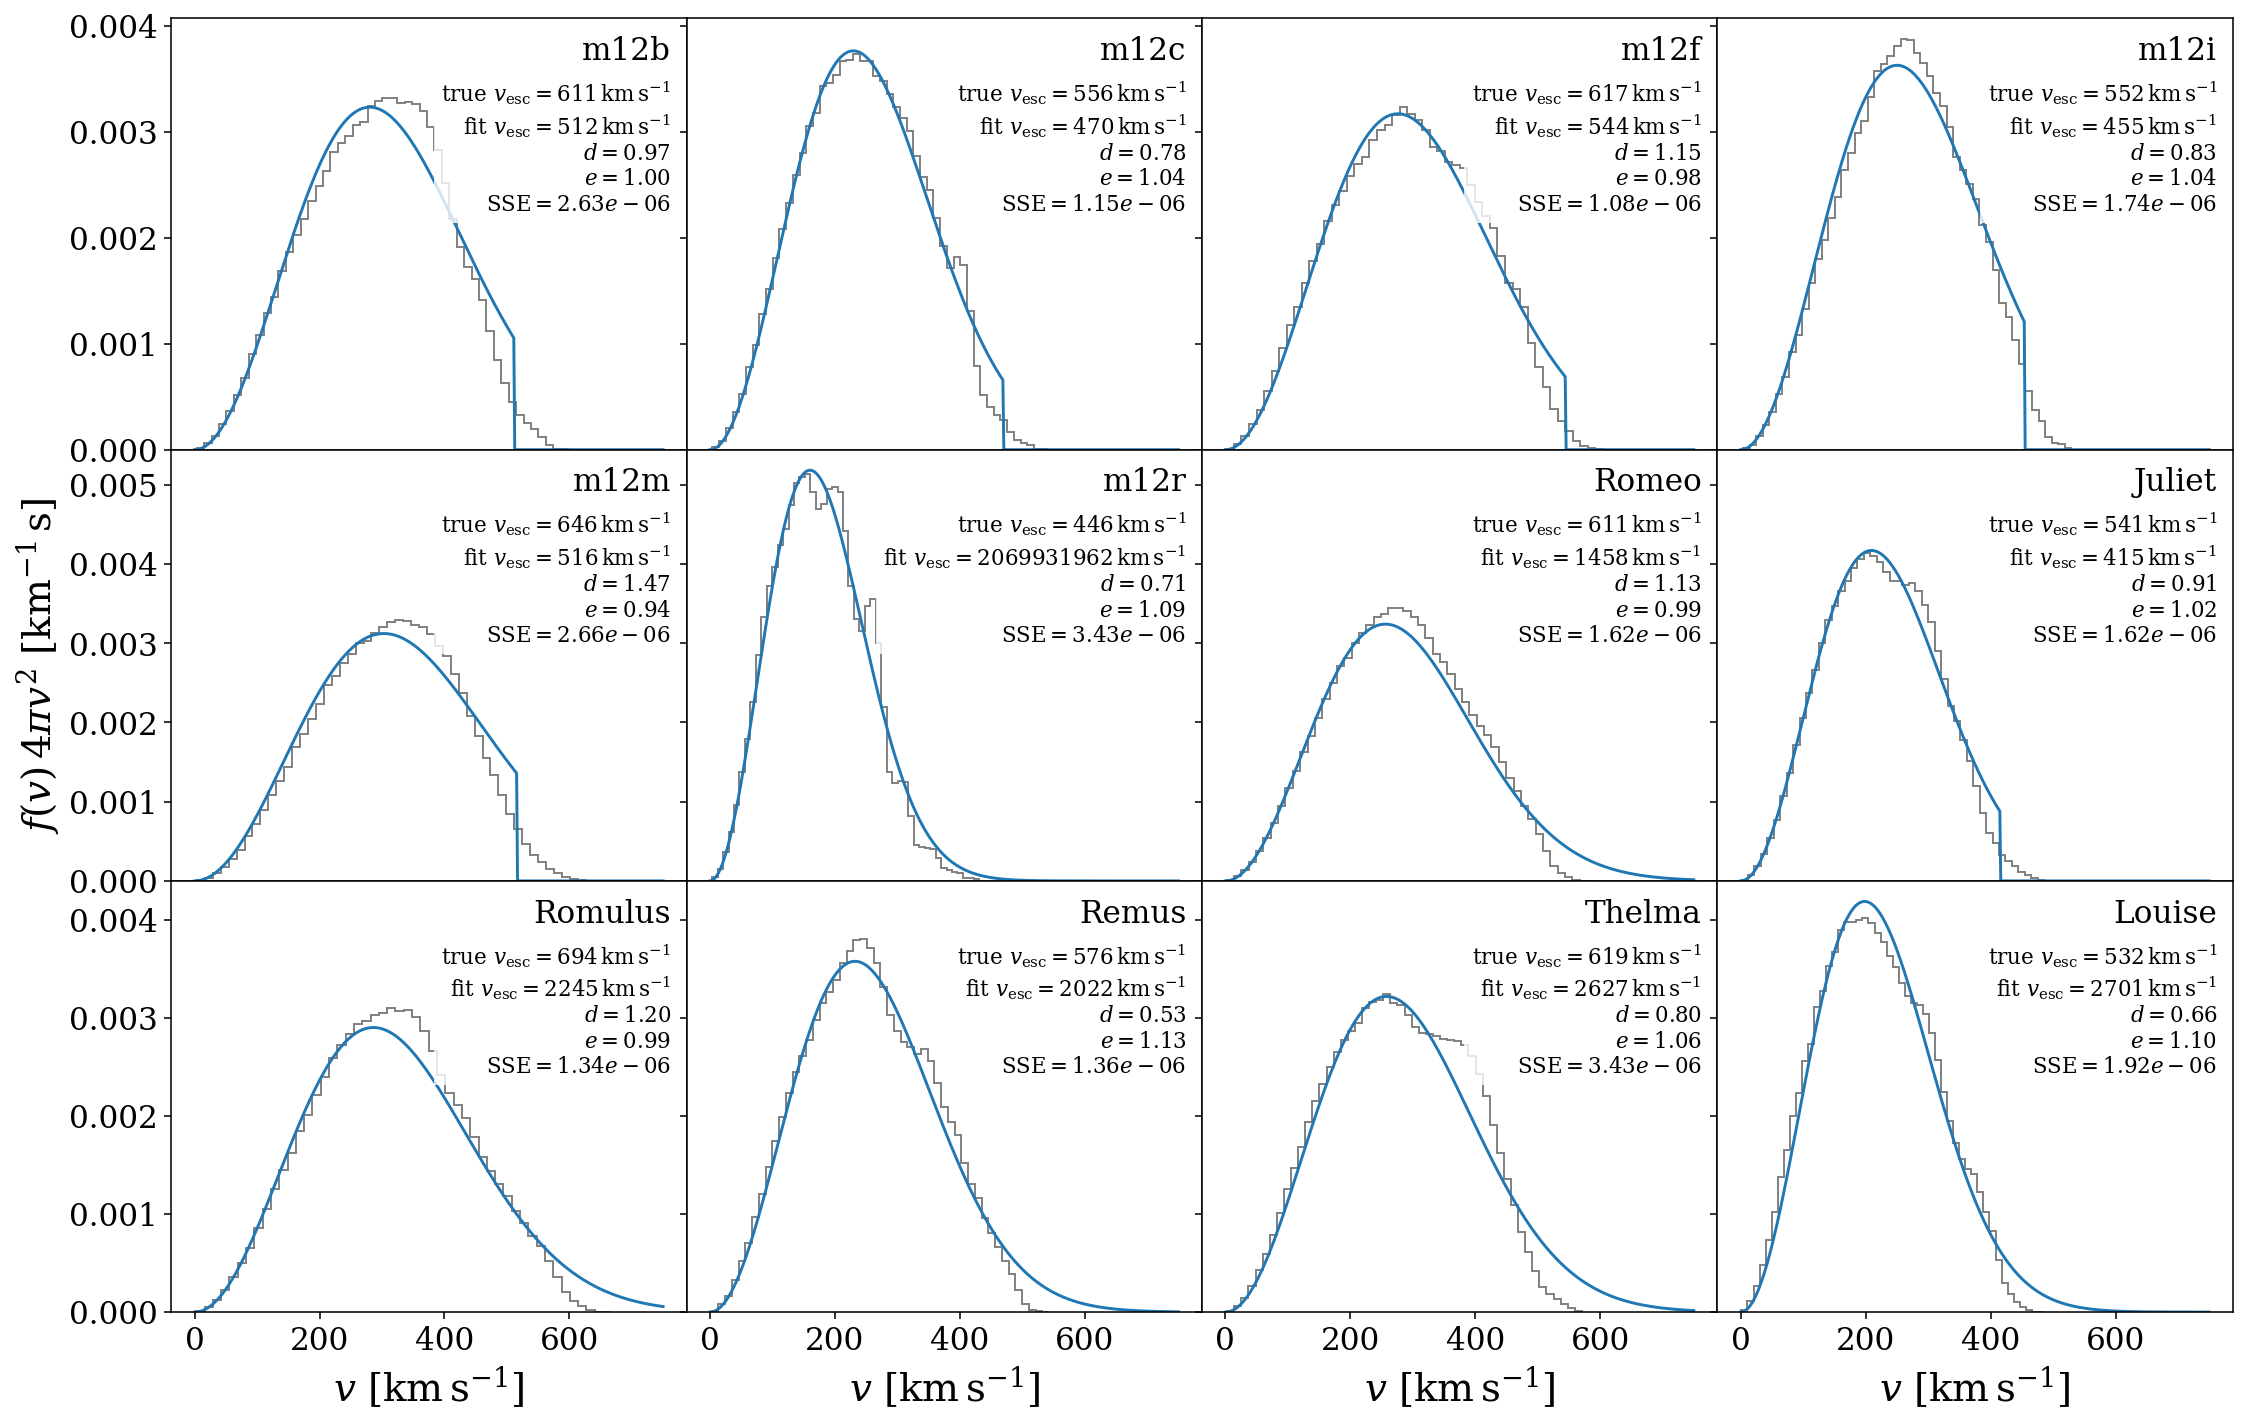

In [40]:
def fit_dehj():
    df = dm_den.load_data('dm_stats_20221208.h5').drop(['m12w', 'm12z'])
    
    fig,axs=plt.subplots(3,4,figsize=(19.,12.), sharey='row',
                         sharex=True, dpi=140)
    axs=axs.ravel()
    fig.subplots_adjust(wspace=0.,hspace=0.)
    
    for i, gal in enumerate(df.index):
        pdf = pdfs_v[gal]
        bins = pdf['bins']
        vs_truth = (bins[1:] + bins[:-1]) / 2.
        vs_postfit = np.linspace(0., 750., 500)
        ps_truth = pdf['ps']
        vc = df.loc[gal, 'v_dot_phihat_disc(T<=1e4)']
        vesc = vesc_dict[gal]['ve_avg']
        
        X = [vs_truth, np.repeat(vc, len(vs_truth))]
        
        res_dehj, _ = scipy.optimize.curve_fit(max_dehj, X, ps_truth, 
                                               p0=[0.8, 1., 2., 1.])
        ps_predicted = trunc_max_simple(vs_truth, 
                                        res_dehj[0] * vc ** res_dehj[1], 
                                        res_dehj[2] * vc ** res_dehj[3])
        sse = ((ps_truth - ps_predicted)**2.).sum()
        
        axs[i].stairs(ps_truth, bins, color='grey')
        axs[i].plot(vs_postfit, 
                    trunc_max_simple(vs_postfit, 
                                     res_dehj[0] * vc ** res_dehj[1], 
                                     res_dehj[2] * vc ** res_dehj[3]))
        axs[i].grid()
        
        loc=[0.97,0.96]
        kwargs_txt = dict(fontsize=16., xycoords='axes fraction',
                      va='top', ha='right', 
                      bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        axs[i].annotate(gal, loc,
                        **kwargs_txt)
        loc[1] -= 0.1
        kwargs_txt['fontsize'] = 11.
        axs[i].annotate('true $v_\mathrm{{esc}}'
                        '={0:0.0f}\,\mathrm{{km\,s^{{-1}}}}$\n'
                        'fit $v_\mathrm{{esc}}'
                        '={1:0.0f}\,\mathrm{{km\,s^{{-1}}}}$\n'
                        '$d={3:0.2f}$\n'
                        '$e={4:0.2f}$\n'
                        '$\mathrm{{SSE}}={2:0.2e}$'
                        .format(vesc, 
                                res_dehj[2] * vc ** res_dehj[3],
                                sse, res_dehj[0], res_dehj[1]),
                        loc, **kwargs_txt)
    for i in [4]:
        axs[i].set_ylabel('$f(v)\,4\pi v^2\ [\mathrm{km^{-1}\,s}]$')
    for ax in axs[-4:]:
        ax.set_xlabel('$v\ [\mathrm{km\,s^{-1}}]$')
    plt.show()

fit_dehj()

# Fitting $v_\mathrm{esc}$ as its own parameter

/tmp/ipykernel_18352/3170528422.py:22: RuntimeWarning: divide by zero encountered in true_divide
  f /= N
/export/nfs0home/pstaudt/miniconda3/envs/dm_stats/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_18352/3170528422.py:22: RuntimeWarning: divide by zero encountered in true_divide
  f /= N
/export/nfs0home/pstaudt/miniconda3/envs/dm_stats/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_18352/3170528422.py:22: RuntimeWarning: divide by zero encountered in true_divide
  f /= N
/tmp/ipykernel_18352/3170528422.py:22: RuntimeWarning: divide by zero encountered in true_divide
  f /= N
/tmp/ipykernel_18352/3170528422.py:22: RuntimeWarning: divide by zero encountered in true_divide
  f /= N
/tmp/ipykernel_18352/3170528422.py:22: RuntimeWarning: divide by zero encountered in true_divide
  f /

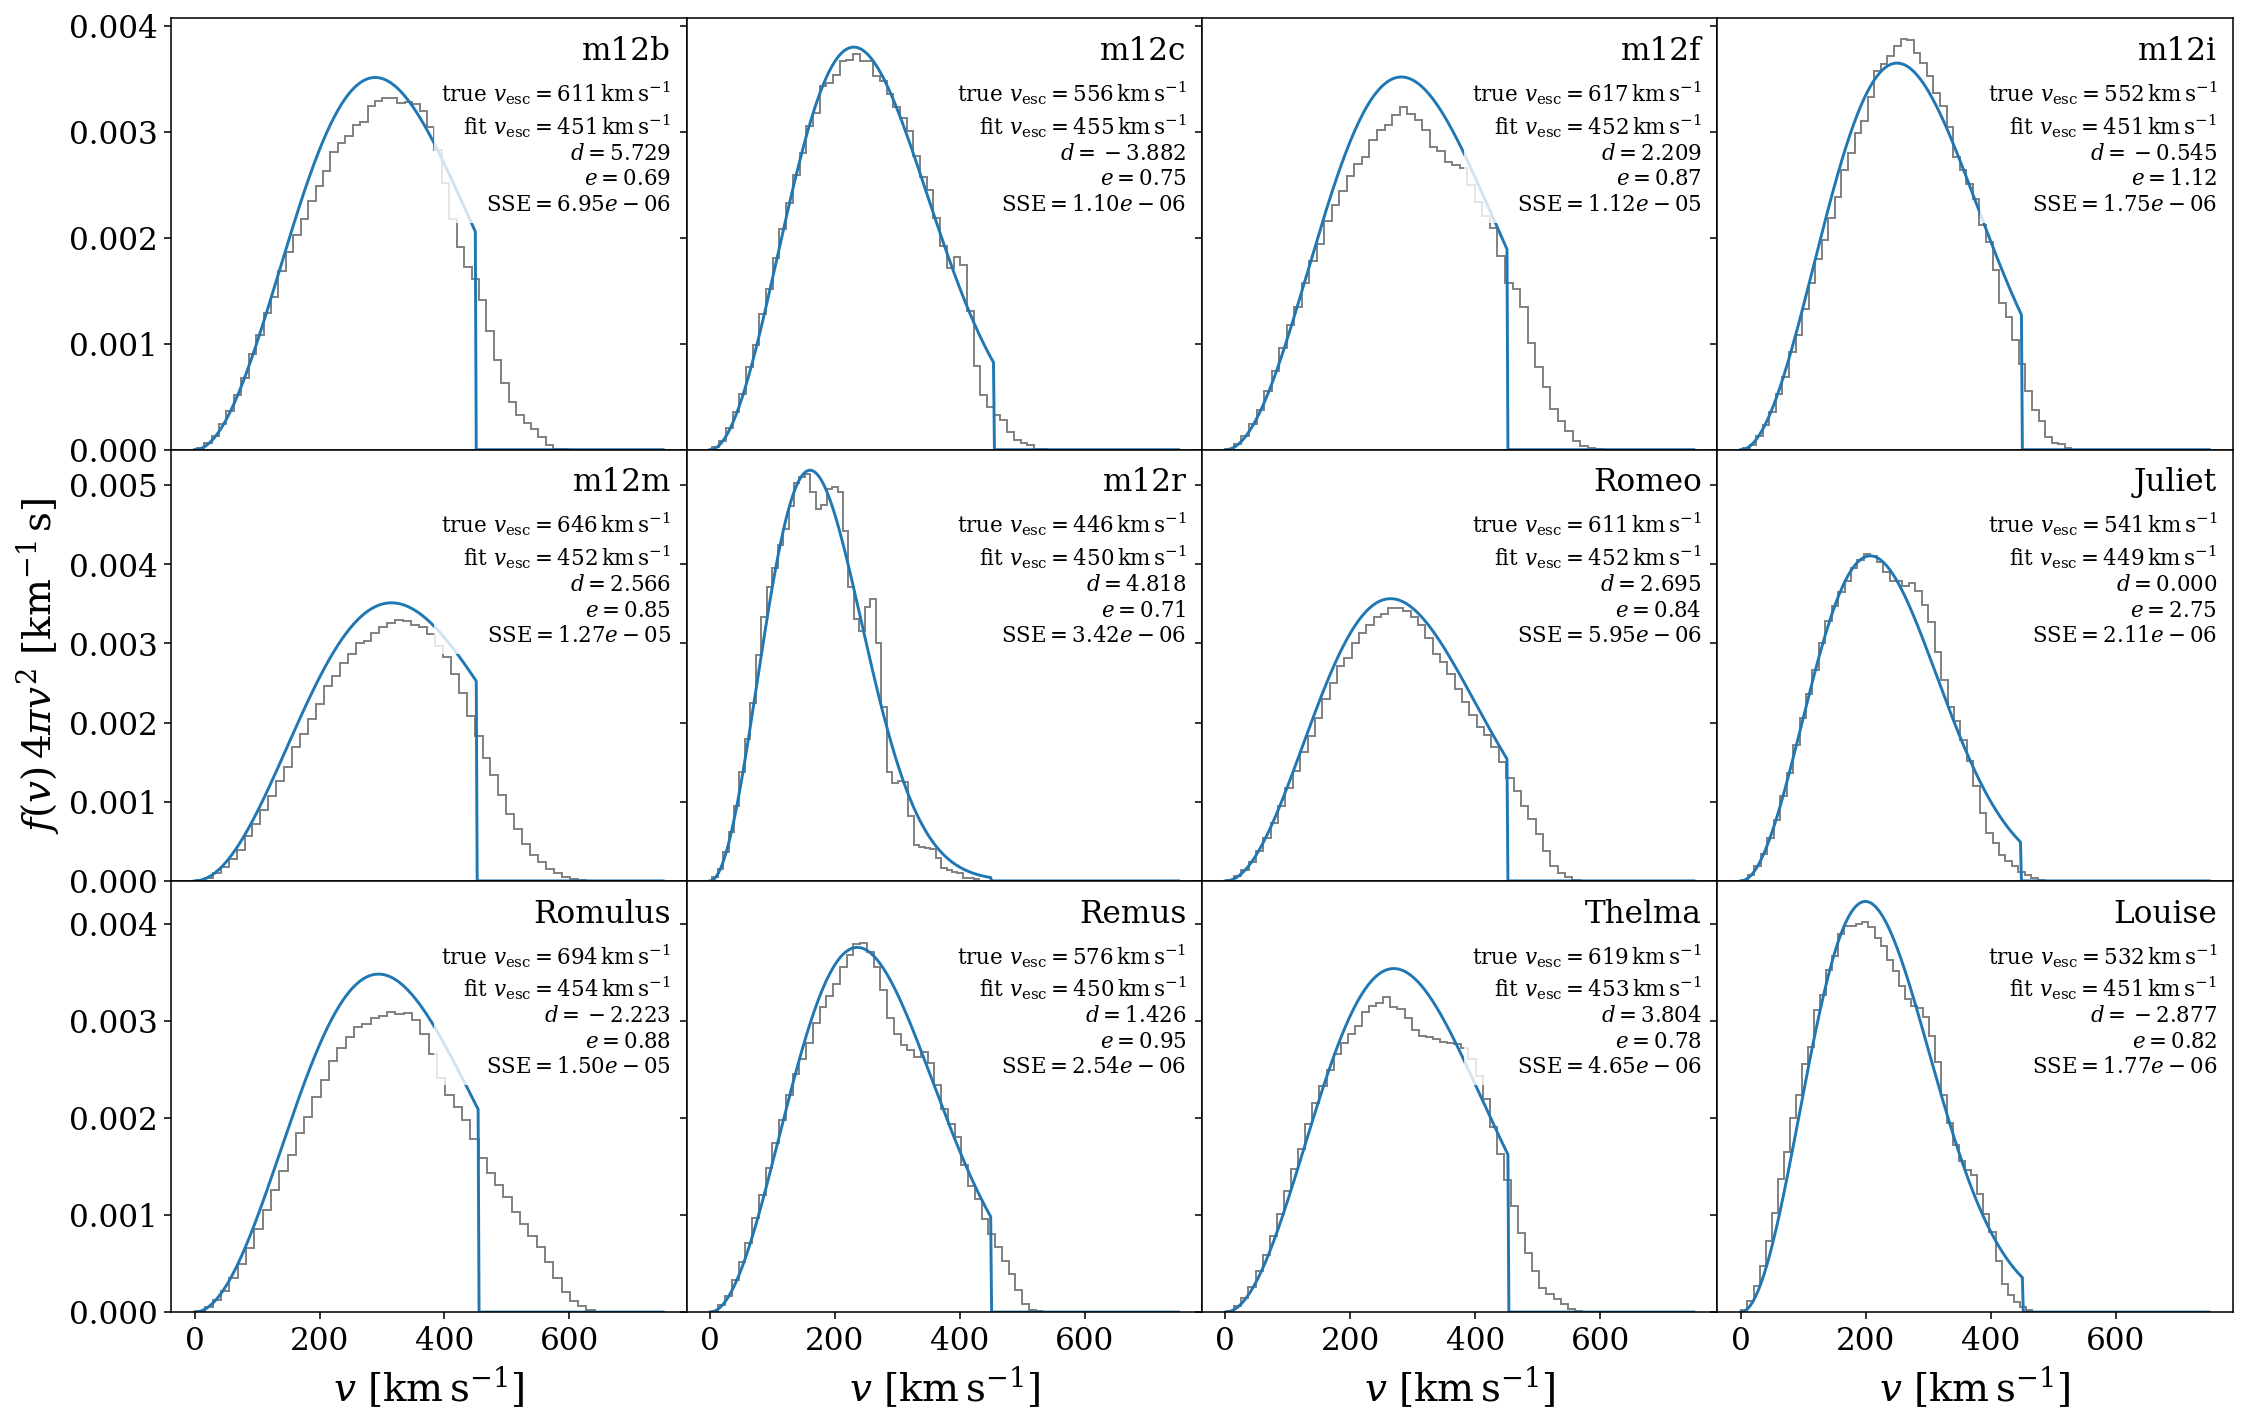

In [43]:
def fit_de_vesc():
    df = dm_den.load_data('dm_stats_20221208.h5').drop(['m12w', 'm12z'])
    
    fig,axs=plt.subplots(3,4,figsize=(19.,12.), sharey='row',
                         sharex=True, dpi=140)
    axs=axs.ravel()
    fig.subplots_adjust(wspace=0.,hspace=0.)
    
    for i, gal in enumerate(df.index):
        pdf = pdfs_v[gal]
        bins = pdf['bins']
        vs_truth = (bins[1:] + bins[:-1]) / 2.
        vs_postfit = np.linspace(0., 750., 500)
        ps_truth = pdf['ps']
        vc = df.loc[gal, 'v_dot_phihat_disc(T<=1e4)']
        vesc = vesc_dict[gal]['ve_avg']
        
        def sse_max_de_vesc(params):
            d, e, vesc = params
            ps_predicted = trunc_max_simple(
                                        vs_truth,
                                        d * vc ** e, 
                                        vesc)
            sse = ((ps_predicted - ps_truth)**2.).sum()
            return sse
        
        res_de_vesc = scipy.optimize.basinhopping(sse_max_de_vesc, 
                                                  x0=[0.8, 1., 450.])
        #print(res_de_vesc)
        
        axs[i].stairs(ps_truth, bins, color='grey')
        axs[i].plot(vs_postfit, 
                    trunc_max_simple(vs_postfit, 
                                     res_de_vesc.x[0] * vc ** res_de_vesc.x[1], 
                                     res_de_vesc.x[2]))
        axs[i].grid()
        
        loc=[0.97,0.96]
        kwargs_txt = dict(fontsize=16., xycoords='axes fraction',
                      va='top', ha='right', 
                      bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
        axs[i].annotate(gal, loc,
                        **kwargs_txt)
        loc[1] -= 0.1
        kwargs_txt['fontsize'] = 11.
        axs[i].annotate('true $v_\mathrm{{esc}}'
                        '={0:0.0f}\,\mathrm{{km\,s^{{-1}}}}$\n'
                        'fit $v_\mathrm{{esc}}'
                        '={1:0.0f}\,\mathrm{{km\,s^{{-1}}}}$\n'
                        '$d={3:0.3f}$\n'
                        '$e={4:0.2f}$\n'
                        '$\mathrm{{SSE}}={2:0.2e}$'
                        .format(vesc, 
                                res_de_vesc.x[2],
                                res_de_vesc.fun, *res_de_vesc.x[:2]),
                        loc, **kwargs_txt)
    for i in [4]:
        axs[i].set_ylabel('$f(v)\,4\pi v^2\ [\mathrm{km^{-1}\,s}]$')
    for ax in axs[-4:]:
        ax.set_xlabel('$v\ [\mathrm{km\,s^{-1}}]$')
    plt.show()
    return None

fit_de_vesc()